# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-lc'
epochs = 10
batch_size = 32
sequence_length = 64

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [9]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


In [10]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [11]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [12]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [13]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [14]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [15]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=sequence_length, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [16]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [17]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [18]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [19]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def least_confidence_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    start_time = time.time()
    
    uncertainties = []
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits

        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in least_confident_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [21]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
        
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [22]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5536, Accuracy: 0.8278, F1 Micro: 0.0032, F1 Macro: 0.0013
Epoch 2/10, Train Loss: 0.4221, Accuracy: 0.8278, F1 Micro: 0.0011, F1 Macro: 0.0005
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.378, Accuracy: 0.829, F1 Micro: 0.015, F1 Macro: 0.0067
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3611, Accuracy: 0.8568, F1 Micro: 0.3644, F1 Macro: 0.115
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3321, Accuracy: 0.8729, F1 Micro: 0.521, F1 Macro: 0.2337
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2988, Accuracy: 0.8748, F1 Micro: 0.5399, F1 Macro: 0.2748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2642, Accuracy: 0.8807, F1 Micro: 0.5811, F1 Macro: 0.295
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2283, Accuracy: 0.881, F1 Micro: 0.5824, F1 Macro: 0.3312
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1965, Accuracy: 0.8829, F1 Micro: 0.5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3972, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2472, Accuracy: 0.8279, F1 Micro: 0.0018, F1 Macro: 0.0008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2119, Accuracy: 0.8594, F1 Micro: 0.4866, F1 Macro: 0.2208
Epoch 4/10, Train Loss: 0.1747, Accuracy: 0.8602, F1 Micro: 0.3864, F1 Macro: 0.1781
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1556, Accuracy: 0.8741, F1 Micro: 0.5365, F1 Macro: 0.2516
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1256, Accuracy: 0.8782, F1 Micro: 0.5862, F1 Macro: 0.3038
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1056, Accuracy: 0.8784, F1 Micro: 0.6043, F1 Macro: 0.3701
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.094, Accuracy: 0.8822, F1 Micro: 0.6421, F1 Macro: 0.4436
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0861, Accuracy: 0.8826, F1 Micro: 0.6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3207, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2038, Accuracy: 0.8357, F1 Micro: 0.1152, F1 Macro: 0.0451
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1653, Accuracy: 0.8638, F1 Micro: 0.5288, F1 Macro: 0.2483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.144, Accuracy: 0.8721, F1 Micro: 0.5806, F1 Macro: 0.2852
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.8722, F1 Micro: 0.6337, F1 Macro: 0.3404
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.8831, F1 Micro: 0.6326, F1 Macro: 0.3595
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.8845, F1 Micro: 0.6382, F1 Macro: 0.4355
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.8853, F1 Micro: 0.6315, F1 Macro: 0.422
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0612, Accuracy: 0.887, F1 Micro: 0.6516, F1 Macro: 0.415
Higher F1 achi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2853, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1803, Accuracy: 0.8471, F1 Micro: 0.2726, F1 Macro: 0.1106
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1452, Accuracy: 0.8681, F1 Micro: 0.5162, F1 Macro: 0.245
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1246, Accuracy: 0.8752, F1 Micro: 0.5325, F1 Macro: 0.2748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0976, Accuracy: 0.8811, F1 Micro: 0.6032, F1 Macro: 0.3801
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0787, Accuracy: 0.8875, F1 Micro: 0.653, F1 Macro: 0.4091
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.8863, F1 Micro: 0.6658, F1 Macro: 0.4379
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.8894, F1 Micro: 0.6362, F1 Macro: 0.425
Epoch 9/10, Train Loss: 0.0463, Accuracy: 0.8908, F1 Micro: 0.6489, F1 Macro: 0.4218
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2699, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1773, Accuracy: 0.8398, F1 Micro: 0.1605, F1 Macro: 0.0661
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1383, Accuracy: 0.8719, F1 Micro: 0.6005, F1 Macro: 0.2951
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.119, Accuracy: 0.8854, F1 Micro: 0.6158, F1 Macro: 0.3084
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0932, Accuracy: 0.8865, F1 Micro: 0.6514, F1 Macro: 0.3657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0732, Accuracy: 0.8825, F1 Micro: 0.6609, F1 Macro: 0.4097
Epoch 7/10, Train Loss: 0.0598, Accuracy: 0.8882, F1 Micro: 0.6485, F1 Macro: 0.4526
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.8889, F1 Micro: 0.6717, F1 Macro: 0.4269
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.8882, F1 Micro: 0.6683, F1 Macro: 0.4699
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2697, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.183, Accuracy: 0.8497, F1 Micro: 0.2881, F1 Macro: 0.1386
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1529, Accuracy: 0.8789, F1 Micro: 0.5576, F1 Macro: 0.2849
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1225, Accuracy: 0.8856, F1 Micro: 0.6497, F1 Macro: 0.3681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0938, Accuracy: 0.8824, F1 Micro: 0.6775, F1 Macro: 0.4249
Epoch 6/10, Train Loss: 0.0649, Accuracy: 0.8927, F1 Micro: 0.6647, F1 Macro: 0.4449
Epoch 7/10, Train Loss: 0.0574, Accuracy: 0.8909, F1 Micro: 0.6524, F1 Macro: 0.4592
Epoch 8/10, Train Loss: 0.0462, Accuracy: 0.8926, F1 Micro: 0.6443, F1 Macro: 0.443
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.8939, F1 Micro: 0.6798, F1 Macro: 0.4585
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.276, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1932, Accuracy: 0.8689, F1 Micro: 0.4617, F1 Macro: 0.2191
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.157, Accuracy: 0.8898, F1 Micro: 0.6501, F1 Macro: 0.3543
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1234, Accuracy: 0.8922, F1 Micro: 0.6843, F1 Macro: 0.4408
Epoch 5/10, Train Loss: 0.0955, Accuracy: 0.8963, F1 Micro: 0.6755, F1 Macro: 0.3992
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0736, Accuracy: 0.8957, F1 Micro: 0.6915, F1 Macro: 0.4732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0612, Accuracy: 0.9002, F1 Micro: 0.696, F1 Macro: 0.4804
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.9009, F1 Micro: 0.7113, F1 Macro: 0.5079
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.904, F1 Micro: 0.7064, F1 Macro: 0.5061
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2844, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2019, Accuracy: 0.88, F1 Micro: 0.5794, F1 Macro: 0.3039
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1548, Accuracy: 0.8933, F1 Micro: 0.6833, F1 Macro: 0.445
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1277, Accuracy: 0.8941, F1 Micro: 0.6972, F1 Macro: 0.5014
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0913, Accuracy: 0.9006, F1 Micro: 0.7035, F1 Macro: 0.5
Epoch 6/10, Train Loss: 0.0712, Accuracy: 0.9027, F1 Micro: 0.6874, F1 Macro: 0.4796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0596, Accuracy: 0.9019, F1 Micro: 0.7167, F1 Macro: 0.5032
Epoch 8/10, Train Loss: 0.0462, Accuracy: 0.902, F1 Micro: 0.7015, F1 Macro: 0.5054
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0448, Accuracy: 0.9035, F1 Micro: 0.7217, F1 Macro: 0.5164
Epoch 10/10, Trai

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2977, Accuracy: 0.837, F1 Micro: 0.1097, F1 Macro: 0.044
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2041, Accuracy: 0.8929, F1 Micro: 0.6569, F1 Macro: 0.3995
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1582, Accuracy: 0.9021, F1 Micro: 0.7172, F1 Macro: 0.5246
Epoch 4/10, Train Loss: 0.1205, Accuracy: 0.9029, F1 Micro: 0.7152, F1 Macro: 0.5455
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0953, Accuracy: 0.9099, F1 Micro: 0.7337, F1 Macro: 0.5681
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0786, Accuracy: 0.9112, F1 Micro: 0.74, F1 Macro: 0.5733
Epoch 7/10, Train Loss: 0.0587, Accuracy: 0.9048, F1 Micro: 0.726, F1 Macro: 0.5794
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9123, F1 Micro: 0.7333, F1 Macro: 0.5626
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.9142, F1 Micro: 0.742, F1 Macro: 0.5847
Epoch 10/10, Train Loss: 0.0379, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3128, Accuracy: 0.8418, F1 Micro: 0.1688, F1 Macro: 0.0687
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2089, Accuracy: 0.8982, F1 Micro: 0.6702, F1 Macro: 0.4653
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.158, Accuracy: 0.9036, F1 Micro: 0.6853, F1 Macro: 0.4955
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1255, Accuracy: 0.9037, F1 Micro: 0.7238, F1 Macro: 0.563
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0996, Accuracy: 0.9072, F1 Micro: 0.7331, F1 Macro: 0.5758
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0764, Accuracy: 0.9133, F1 Micro: 0.7459, F1 Macro: 0.5887
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0638, Accuracy: 0.9137, F1 Micro: 0.7488, F1 Macro: 0.587
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9158, F1 Micro: 0.7502, F1 Macro: 0.6014
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9114, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3173, Accuracy: 0.8619, F1 Micro: 0.3785, F1 Macro: 0.1929
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2104, Accuracy: 0.9021, F1 Micro: 0.7021, F1 Macro: 0.5337
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1658, Accuracy: 0.9087, F1 Micro: 0.7308, F1 Macro: 0.5577
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1264, Accuracy: 0.9124, F1 Micro: 0.748, F1 Macro: 0.5939
Epoch 5/10, Train Loss: 0.0965, Accuracy: 0.9178, F1 Micro: 0.7381, F1 Macro: 0.57
Epoch 6/10, Train Loss: 0.0761, Accuracy: 0.9169, F1 Micro: 0.7464, F1 Macro: 0.5955
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0634, Accuracy: 0.9167, F1 Micro: 0.7528, F1 Macro: 0.613
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.912, F1 Micro: 0.7423, F1 Macro: 0.5941
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9166, F1 Micro: 0.7524, F1 Macro: 0.6065
Epoch 10/10, Train Loss: 0.0383, Accuracy: 0.9162, F1 Micro: 0.746, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3241, Accuracy: 0.8811, F1 Micro: 0.5673, F1 Macro: 0.3797
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2105, Accuracy: 0.9047, F1 Micro: 0.6839, F1 Macro: 0.5188
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1622, Accuracy: 0.9129, F1 Micro: 0.7362, F1 Macro: 0.5686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1221, Accuracy: 0.9156, F1 Micro: 0.7436, F1 Macro: 0.5821
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0983, Accuracy: 0.9153, F1 Micro: 0.7557, F1 Macro: 0.6173
Epoch 6/10, Train Loss: 0.0788, Accuracy: 0.9117, F1 Micro: 0.7505, F1 Macro: 0.6115
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0619, Accuracy: 0.9169, F1 Micro: 0.7568, F1 Macro: 0.6037
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9162, F1 Micro: 0.7484, F1 Macro: 0.6128
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.9138, F1 Micro: 0.7519, F1 Macro: 0.6109
Epoch 10/10, Train Loss: 0.038, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3213, Accuracy: 0.8858, F1 Micro: 0.5733, F1 Macro: 0.3736
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2109, Accuracy: 0.9083, F1 Micro: 0.719, F1 Macro: 0.5566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1633, Accuracy: 0.9091, F1 Micro: 0.7448, F1 Macro: 0.6017
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1303, Accuracy: 0.9072, F1 Micro: 0.7475, F1 Macro: 0.601
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1013, Accuracy: 0.9165, F1 Micro: 0.7491, F1 Macro: 0.6015
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.08, Accuracy: 0.9136, F1 Micro: 0.7538, F1 Macro: 0.6025
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0642, Accuracy: 0.9167, F1 Micro: 0.7583, F1 Macro: 0.608
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9177, F1 Micro: 0.7571, F1 Macro: 0.6198
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0448, Accuracy: 0.9196, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3284, Accuracy: 0.8929, F1 Micro: 0.6508, F1 Macro: 0.4382
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2128, Accuracy: 0.9041, F1 Micro: 0.6649, F1 Macro: 0.471
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1644, Accuracy: 0.9169, F1 Micro: 0.7522, F1 Macro: 0.6015
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1279, Accuracy: 0.9201, F1 Micro: 0.7613, F1 Macro: 0.61
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1023, Accuracy: 0.9181, F1 Micro: 0.7633, F1 Macro: 0.62
Epoch 6/10, Train Loss: 0.0794, Accuracy: 0.9187, F1 Micro: 0.7608, F1 Macro: 0.6065
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0618, Accuracy: 0.9199, F1 Micro: 0.7642, F1 Macro: 0.6145
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.9168, F1 Micro: 0.7605, F1 Macro: 0.6127
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.9195, F1 Micro: 0.7604, F1 Macro: 0.6238
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3264, Accuracy: 0.8866, F1 Micro: 0.6103, F1 Macro: 0.4331
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2081, Accuracy: 0.9103, F1 Micro: 0.7103, F1 Macro: 0.5299
Epoch 3/10, Train Loss: 0.1646, Accuracy: 0.9089, F1 Micro: 0.6937, F1 Macro: 0.5644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1333, Accuracy: 0.9187, F1 Micro: 0.7515, F1 Macro: 0.6037
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0997, Accuracy: 0.9197, F1 Micro: 0.7574, F1 Macro: 0.611
Epoch 6/10, Train Loss: 0.0766, Accuracy: 0.9155, F1 Micro: 0.7536, F1 Macro: 0.6169
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.9202, F1 Micro: 0.7651, F1 Macro: 0.6334
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.9153, F1 Micro: 0.7567, F1 Macro: 0.6188
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.9182, F1 Micro: 0.7521, F1 Macro: 0.6354
Epoch 10/10, Train Loss: 0.0379, Accuracy: 0.9186, F1 Micro: 0.7617, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3261, Accuracy: 0.892, F1 Micro: 0.6528, F1 Macro: 0.4346
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2111, Accuracy: 0.9092, F1 Micro: 0.7243, F1 Macro: 0.5817
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1665, Accuracy: 0.9095, F1 Micro: 0.7484, F1 Macro: 0.5877
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1316, Accuracy: 0.92, F1 Micro: 0.7523, F1 Macro: 0.6093
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.102, Accuracy: 0.9171, F1 Micro: 0.7667, F1 Macro: 0.6106
Epoch 6/10, Train Loss: 0.0767, Accuracy: 0.9213, F1 Micro: 0.7639, F1 Macro: 0.6197
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9206, F1 Micro: 0.7681, F1 Macro: 0.637
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.916, F1 Micro: 0.7588, F1 Macro: 0.6277
Epoch 9/10, Train Loss: 0.0454, Accuracy: 0.9194, F1 Micro: 0.7625, F1 Macro: 0.6219
Epoch 10/10, Train Loss: 0.0381, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3255, Accuracy: 0.8885, F1 Micro: 0.5874, F1 Macro: 0.3421
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2137, Accuracy: 0.9114, F1 Micro: 0.7185, F1 Macro: 0.5545
Epoch 3/10, Train Loss: 0.1632, Accuracy: 0.9152, F1 Micro: 0.7146, F1 Macro: 0.5692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1314, Accuracy: 0.9204, F1 Micro: 0.761, F1 Macro: 0.6109
Epoch 5/10, Train Loss: 0.1028, Accuracy: 0.9123, F1 Micro: 0.7597, F1 Macro: 0.6116
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0806, Accuracy: 0.9208, F1 Micro: 0.7615, F1 Macro: 0.6168
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.9191, F1 Micro: 0.7467, F1 Macro: 0.611
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.9237, F1 Micro: 0.7712, F1 Macro: 0.6394
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9213, F1 Micro: 0.7641, F1 Macro: 0.6345
Epoch 10/10, Train Loss: 0.0363, Accuracy: 0.9213, F1 Micro: 0.7619, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3263, Accuracy: 0.8957, F1 Micro: 0.6498, F1 Macro: 0.4488
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2078, Accuracy: 0.9134, F1 Micro: 0.7262, F1 Macro: 0.5675
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1607, Accuracy: 0.9193, F1 Micro: 0.7554, F1 Macro: 0.5935
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1313, Accuracy: 0.9211, F1 Micro: 0.7617, F1 Macro: 0.6075
Epoch 5/10, Train Loss: 0.0995, Accuracy: 0.9215, F1 Micro: 0.7582, F1 Macro: 0.6198
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0834, Accuracy: 0.9214, F1 Micro: 0.7626, F1 Macro: 0.6269
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0622, Accuracy: 0.9193, F1 Micro: 0.7688, F1 Macro: 0.6351
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.9188, F1 Micro: 0.7636, F1 Macro: 0.6312
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9235, F1 Micro: 0.7704, F1 Macro: 0.6397
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3255, Accuracy: 0.8913, F1 Micro: 0.6076, F1 Macro: 0.4236
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2125, Accuracy: 0.9089, F1 Micro: 0.7305, F1 Macro: 0.5518
Epoch 3/10, Train Loss: 0.1656, Accuracy: 0.9146, F1 Micro: 0.7159, F1 Macro: 0.5838
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1347, Accuracy: 0.917, F1 Micro: 0.7595, F1 Macro: 0.6167
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1044, Accuracy: 0.9228, F1 Micro: 0.7708, F1 Macro: 0.6207
Epoch 6/10, Train Loss: 0.0781, Accuracy: 0.9237, F1 Micro: 0.7687, F1 Macro: 0.6315
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9214, F1 Micro: 0.7594, F1 Macro: 0.6303
Epoch 8/10, Train Loss: 0.055, Accuracy: 0.9195, F1 Micro: 0.7673, F1 Macro: 0.6242
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.9197, F1 Micro: 0.7669, F1 Macro: 0.6414
Epoch 10/10, Train Loss: 0.0406, Accuracy: 0.9205, F1 Micro: 0.7684, F1 Macro: 0.6389
Iteration 9016: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3304, Accuracy: 0.9005, F1 Micro: 0.6896, F1 Macro: 0.4874
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2127, Accuracy: 0.9147, F1 Micro: 0.7332, F1 Macro: 0.5554
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1646, Accuracy: 0.9129, F1 Micro: 0.7535, F1 Macro: 0.6116
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1306, Accuracy: 0.9218, F1 Micro: 0.7687, F1 Macro: 0.6148
Epoch 5/10, Train Loss: 0.1015, Accuracy: 0.9235, F1 Micro: 0.7645, F1 Macro: 0.6262
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0839, Accuracy: 0.9236, F1 Micro: 0.7743, F1 Macro: 0.645
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.9199, F1 Micro: 0.7693, F1 Macro: 0.6387
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.923, F1 Micro: 0.7711, F1 Macro: 0.6581
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9158, F1 Micro: 0.7624, F1 Macro: 0.6416
Epoch 10/10, Train Loss: 0.0394, Accuracy: 0.9161, F1 Micro: 0.7596, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.327, Accuracy: 0.8934, F1 Micro: 0.6309, F1 Macro: 0.4394
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2129, Accuracy: 0.9145, F1 Micro: 0.7297, F1 Macro: 0.5493
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1696, Accuracy: 0.92, F1 Micro: 0.7658, F1 Macro: 0.6119
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1262, Accuracy: 0.9235, F1 Micro: 0.7704, F1 Macro: 0.6158
Epoch 5/10, Train Loss: 0.1037, Accuracy: 0.9191, F1 Micro: 0.7692, F1 Macro: 0.6344
Epoch 6/10, Train Loss: 0.0885, Accuracy: 0.9205, F1 Micro: 0.742, F1 Macro: 0.6251
Epoch 7/10, Train Loss: 0.0661, Accuracy: 0.9202, F1 Micro: 0.7664, F1 Macro: 0.6454
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.9226, F1 Micro: 0.7686, F1 Macro: 0.6431
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.9219, F1 Micro: 0.7659, F1 Macro: 0.6357
Epoch 10/10, Train Loss: 0.0409, Accuracy: 0.9209, F1 Micro: 0.7689, F1 Macro: 0.6561
Iteration 9218: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3242, Accuracy: 0.8985, F1 Micro: 0.6631, F1 Macro: 0.4529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2099, Accuracy: 0.9149, F1 Micro: 0.7281, F1 Macro: 0.5764
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1691, Accuracy: 0.9191, F1 Micro: 0.7705, F1 Macro: 0.6209
Epoch 4/10, Train Loss: 0.1328, Accuracy: 0.9244, F1 Micro: 0.7679, F1 Macro: 0.6288
Epoch 5/10, Train Loss: 0.1091, Accuracy: 0.9196, F1 Micro: 0.7531, F1 Macro: 0.6147
Epoch 6/10, Train Loss: 0.085, Accuracy: 0.921, F1 Micro: 0.7543, F1 Macro: 0.6166
Epoch 7/10, Train Loss: 0.0678, Accuracy: 0.9209, F1 Micro: 0.7694, F1 Macro: 0.6504
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.9206, F1 Micro: 0.7661, F1 Macro: 0.6342
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.9213, F1 Micro: 0.7664, F1 Macro: 0.6482
Epoch 10/10, Train Loss: 0.0387, Accuracy: 0.9213, F1 Micro: 0.7624, F1 Macro: 0.6643
Iteration 9418: Accuracy: 0.9191, F1 Micro: 0.7705, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3245, Accuracy: 0.892, F1 Micro: 0.6121, F1 Macro: 0.437
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2184, Accuracy: 0.9134, F1 Micro: 0.7381, F1 Macro: 0.5689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1665, Accuracy: 0.921, F1 Micro: 0.7584, F1 Macro: 0.6058
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1271, Accuracy: 0.9226, F1 Micro: 0.7725, F1 Macro: 0.6516
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1047, Accuracy: 0.9217, F1 Micro: 0.7775, F1 Macro: 0.658
Epoch 6/10, Train Loss: 0.0816, Accuracy: 0.9241, F1 Micro: 0.7653, F1 Macro: 0.6376
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9219, F1 Micro: 0.7706, F1 Macro: 0.6567
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.924, F1 Micro: 0.7765, F1 Macro: 0.6674
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.9221, F1 Micro: 0.7684, F1 Macro: 0.6856
Epoch 10/10, Train Loss: 0.0395, Accuracy: 0.921, F1 Micro: 0.77, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3235, Accuracy: 0.8997, F1 Micro: 0.6785, F1 Macro: 0.4441
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2152, Accuracy: 0.9169, F1 Micro: 0.7436, F1 Macro: 0.5758
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9173, F1 Micro: 0.7612, F1 Macro: 0.6218
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1312, Accuracy: 0.9203, F1 Micro: 0.7707, F1 Macro: 0.6449
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1072, Accuracy: 0.925, F1 Micro: 0.7716, F1 Macro: 0.6533
Epoch 6/10, Train Loss: 0.0834, Accuracy: 0.921, F1 Micro: 0.7624, F1 Macro: 0.6552
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.9218, F1 Micro: 0.7702, F1 Macro: 0.6544
Epoch 8/10, Train Loss: 0.0572, Accuracy: 0.9198, F1 Micro: 0.7651, F1 Macro: 0.689
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9218, F1 Micro: 0.7718, F1 Macro: 0.6805
Epoch 10/10, Train Loss: 0.0408, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3251, Accuracy: 0.8981, F1 Micro: 0.6969, F1 Macro: 0.5104
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2074, Accuracy: 0.914, F1 Micro: 0.748, F1 Macro: 0.5965
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1631, Accuracy: 0.9211, F1 Micro: 0.7589, F1 Macro: 0.6069
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1317, Accuracy: 0.923, F1 Micro: 0.7598, F1 Macro: 0.629
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1035, Accuracy: 0.921, F1 Micro: 0.7728, F1 Macro: 0.6349
Epoch 6/10, Train Loss: 0.0807, Accuracy: 0.9182, F1 Micro: 0.7641, F1 Macro: 0.6499
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.9181, F1 Micro: 0.7672, F1 Macro: 0.6718
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.9212, F1 Micro: 0.7704, F1 Macro: 0.6765
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9207, F1 Micro: 0.7715, F1 Macro: 0.689
Epoch 10/10, Train Loss: 0.04, Accuracy: 0.9218, F1 Micro: 0.7704, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.328, Accuracy: 0.9002, F1 Micro: 0.6905, F1 Macro: 0.4918
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2157, Accuracy: 0.9148, F1 Micro: 0.7476, F1 Macro: 0.5745
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1633, Accuracy: 0.9203, F1 Micro: 0.7619, F1 Macro: 0.6232
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1342, Accuracy: 0.9251, F1 Micro: 0.7739, F1 Macro: 0.6363
Epoch 5/10, Train Loss: 0.1082, Accuracy: 0.9206, F1 Micro: 0.7712, F1 Macro: 0.6686
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9233, F1 Micro: 0.7784, F1 Macro: 0.6828
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.9246, F1 Micro: 0.7794, F1 Macro: 0.6843
Epoch 8/10, Train Loss: 0.0562, Accuracy: 0.9217, F1 Micro: 0.7742, F1 Macro: 0.691
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9219, F1 Micro: 0.7754, F1 Macro: 0.699
Epoch 10/10, Train Loss: 0.0396, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3277, Accuracy: 0.9005, F1 Micro: 0.687, F1 Macro: 0.5004
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2119, Accuracy: 0.9163, F1 Micro: 0.7507, F1 Macro: 0.593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1664, Accuracy: 0.9141, F1 Micro: 0.7619, F1 Macro: 0.6379
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1311, Accuracy: 0.9197, F1 Micro: 0.7701, F1 Macro: 0.6436
Epoch 5/10, Train Loss: 0.1105, Accuracy: 0.9231, F1 Micro: 0.7698, F1 Macro: 0.6759
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9249, F1 Micro: 0.7706, F1 Macro: 0.6859
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.9249, F1 Micro: 0.7705, F1 Macro: 0.6866
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.925, F1 Micro: 0.7683, F1 Macro: 0.6969
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9232, F1 Micro: 0.7736, F1 Macro: 0.7037
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3255, Accuracy: 0.901, F1 Micro: 0.672, F1 Macro: 0.4673
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2162, Accuracy: 0.9148, F1 Micro: 0.7493, F1 Macro: 0.5963
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.171, Accuracy: 0.9231, F1 Micro: 0.7753, F1 Macro: 0.6544
Epoch 4/10, Train Loss: 0.1371, Accuracy: 0.9242, F1 Micro: 0.7717, F1 Macro: 0.6796
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1079, Accuracy: 0.9237, F1 Micro: 0.7797, F1 Macro: 0.6941
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9227, F1 Micro: 0.778, F1 Macro: 0.6998
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.922, F1 Micro: 0.7676, F1 Macro: 0.6977
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.9244, F1 Micro: 0.7689, F1 Macro: 0.7048
Epoch 9/10, Train Loss: 0.045, Accuracy: 0.9257, F1 Micro: 0.7774, F1 Macro: 0.7108
Epoch 10/10, Train Loss: 0.0406, Accuracy: 0.9215, F1 Micro: 0.773, F1 Macro: 0.7173
Iteration 10535: Accurac

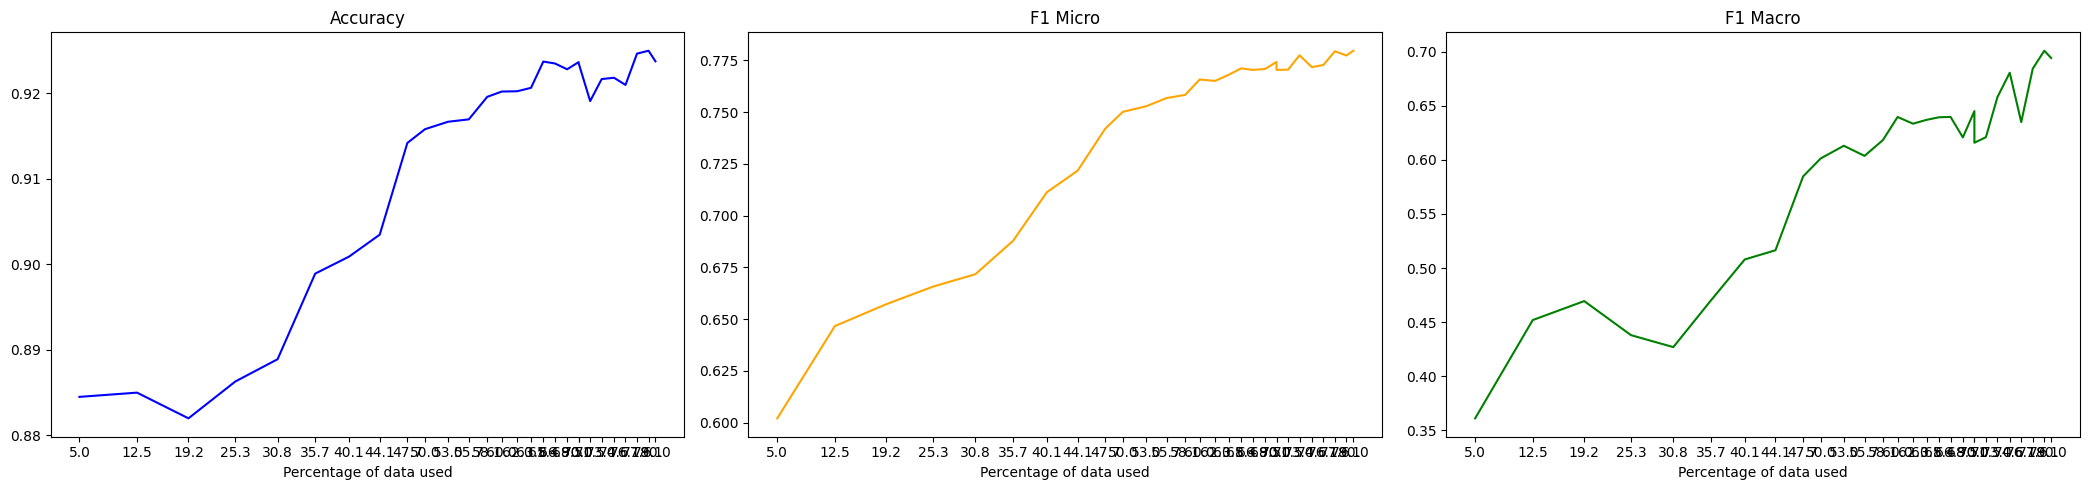

In [23]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5293, Accuracy: 0.8308, F1 Micro: 0.2836, F1 Macro: 0.0632
Epoch 2/10, Train Loss: 0.3913, Accuracy: 0.8331, F1 Micro: 0.0887, F1 Macro: 0.034
Epoch 3/10, Train Loss: 0.3593, Accuracy: 0.8384, F1 Micro: 0.1517, F1 Macro: 0.0564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3366, Accuracy: 0.8637, F1 Micro: 0.4682, F1 Macro: 0.1991
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3206, Accuracy: 0.8697, F1 Micro: 0.5916, F1 Macro: 0.2743
Epoch 6/10, Train Loss: 0.2839, Accuracy: 0.8763, F1 Micro: 0.5685, F1 Macro: 0.2686
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2439, Accuracy: 0.8772, F1 Micro: 0.5917, F1 Macro: 0.2773
Epoch 8/10, Train Loss: 0.2212, Accuracy: 0.8799, F1 Micro: 0.5767, F1 Macro: 0.2824
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1852, Accuracy: 0.8806, F1 Micro: 0.6038, F1 Macro: 0.3067
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.1754, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3684, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2321, Accuracy: 0.8389, F1 Micro: 0.154, F1 Macro: 0.0569
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.187, Accuracy: 0.8686, F1 Micro: 0.5288, F1 Macro: 0.2437
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1554, Accuracy: 0.8749, F1 Micro: 0.5741, F1 Macro: 0.2663
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.8758, F1 Micro: 0.6056, F1 Macro: 0.2794
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1199, Accuracy: 0.8754, F1 Micro: 0.6274, F1 Macro: 0.3115
Epoch 7/10, Train Loss: 0.0932, Accuracy: 0.8807, F1 Micro: 0.6213, F1 Macro: 0.2997
Epoch 8/10, Train Loss: 0.0877, Accuracy: 0.8817, F1 Micro: 0.5877, F1 Macro: 0.3067
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.881, F1 Micro: 0.6193, F1 Macro: 0.3259
Higher F1 achieved, saving model
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3099, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1855, Accuracy: 0.8464, F1 Micro: 0.2541, F1 Macro: 0.0887
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1479, Accuracy: 0.8662, F1 Micro: 0.5886, F1 Macro: 0.2721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1312, Accuracy: 0.8755, F1 Micro: 0.5976, F1 Macro: 0.2783
Epoch 5/10, Train Loss: 0.1039, Accuracy: 0.8783, F1 Micro: 0.5894, F1 Macro: 0.283
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0862, Accuracy: 0.8774, F1 Micro: 0.6311, F1 Macro: 0.3345
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.8814, F1 Micro: 0.6174, F1 Macro: 0.3605
Epoch 8/10, Train Loss: 0.0753, Accuracy: 0.8823, F1 Micro: 0.6288, F1 Macro: 0.3349
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0592, Accuracy: 0.8802, F1 Micro: 0.6465, F1 Macro: 0.3707
Epoch 10/10, Train Loss: 0.0498, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2768, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1714, Accuracy: 0.8585, F1 Micro: 0.3775, F1 Macro: 0.1652
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1423, Accuracy: 0.878, F1 Micro: 0.5992, F1 Macro: 0.2794
Epoch 4/10, Train Loss: 0.1169, Accuracy: 0.8806, F1 Micro: 0.5707, F1 Macro: 0.2642
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0904, Accuracy: 0.8818, F1 Micro: 0.6165, F1 Macro: 0.2983
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0747, Accuracy: 0.8812, F1 Micro: 0.632, F1 Macro: 0.341
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0654, Accuracy: 0.8809, F1 Micro: 0.633, F1 Macro: 0.3779
Epoch 8/10, Train Loss: 0.0565, Accuracy: 0.8843, F1 Micro: 0.625, F1 Macro: 0.3983
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.8845, F1 Micro: 0.6285, F1 Macro: 0.4151
Higher F1 achieved, saving model
Epoch 10/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2676, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1784, Accuracy: 0.8466, F1 Micro: 0.2171, F1 Macro: 0.0813
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1448, Accuracy: 0.8777, F1 Micro: 0.5401, F1 Macro: 0.2518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1158, Accuracy: 0.8814, F1 Micro: 0.648, F1 Macro: 0.3388
Epoch 5/10, Train Loss: 0.0919, Accuracy: 0.885, F1 Micro: 0.6074, F1 Macro: 0.3184
Epoch 6/10, Train Loss: 0.0741, Accuracy: 0.8858, F1 Micro: 0.6268, F1 Macro: 0.4114
Epoch 7/10, Train Loss: 0.0616, Accuracy: 0.8793, F1 Micro: 0.6334, F1 Macro: 0.4465
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.8872, F1 Micro: 0.6659, F1 Macro: 0.4611
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.8806, F1 Micro: 0.6564, F1 Macro: 0.4504
Epoch 10/10, Train Loss: 0.0384, Accuracy: 0.8856, F1 Micro: 0.6638, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2618, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1804, Accuracy: 0.874, F1 Micro: 0.5318, F1 Macro: 0.248
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1441, Accuracy: 0.8838, F1 Micro: 0.6375, F1 Macro: 0.297
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1133, Accuracy: 0.8883, F1 Micro: 0.6536, F1 Macro: 0.3651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.09, Accuracy: 0.887, F1 Micro: 0.6627, F1 Macro: 0.4024
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0725, Accuracy: 0.8861, F1 Micro: 0.6765, F1 Macro: 0.4365
Epoch 7/10, Train Loss: 0.0578, Accuracy: 0.8842, F1 Micro: 0.6701, F1 Macro: 0.4226
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.8922, F1 Micro: 0.6598, F1 Macro: 0.4435
Epoch 9/10, Train Loss: 0.0462, Accuracy: 0.8934, F1 Micro: 0.6683, F1 Macro: 0.451
Epoch 10/10, Train Loss: 0.038, Accuracy: 0.89, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.27, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1865, Accuracy: 0.8805, F1 Micro: 0.6002, F1 Macro: 0.2836
Epoch 3/10, Train Loss: 0.148, Accuracy: 0.8831, F1 Micro: 0.5796, F1 Macro: 0.2948
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1154, Accuracy: 0.8923, F1 Micro: 0.6355, F1 Macro: 0.4063
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0872, Accuracy: 0.8885, F1 Micro: 0.6858, F1 Macro: 0.4589
Epoch 6/10, Train Loss: 0.0697, Accuracy: 0.889, F1 Micro: 0.6776, F1 Macro: 0.4772
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0555, Accuracy: 0.8975, F1 Micro: 0.6981, F1 Macro: 0.4906
Epoch 8/10, Train Loss: 0.0433, Accuracy: 0.8961, F1 Micro: 0.6743, F1 Macro: 0.4947
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.8977, F1 Micro: 0.6918, F1 Macro: 0.5089
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.032, Accuracy: 0.901

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2793, Accuracy: 0.8283, F1 Micro: 0.0072, F1 Macro: 0.0033
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.196, Accuracy: 0.8862, F1 Micro: 0.6081, F1 Macro: 0.2994
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1535, Accuracy: 0.893, F1 Micro: 0.6853, F1 Macro: 0.4391
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.118, Accuracy: 0.894, F1 Micro: 0.6862, F1 Macro: 0.4466
Epoch 5/10, Train Loss: 0.098, Accuracy: 0.9001, F1 Micro: 0.6769, F1 Macro: 0.4626
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0719, Accuracy: 0.9025, F1 Micro: 0.6992, F1 Macro: 0.4991
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0598, Accuracy: 0.9023, F1 Micro: 0.709, F1 Macro: 0.5242
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.9008, F1 Micro: 0.7155, F1 Macro: 0.5145
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9075, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2936, Accuracy: 0.8489, F1 Micro: 0.2555, F1 Macro: 0.1047
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1995, Accuracy: 0.8921, F1 Micro: 0.675, F1 Macro: 0.4311
Epoch 3/10, Train Loss: 0.156, Accuracy: 0.9001, F1 Micro: 0.6642, F1 Macro: 0.478
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1248, Accuracy: 0.903, F1 Micro: 0.7119, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0935, Accuracy: 0.9062, F1 Micro: 0.7196, F1 Macro: 0.531
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0761, Accuracy: 0.9098, F1 Micro: 0.7216, F1 Macro: 0.538
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0569, Accuracy: 0.9097, F1 Micro: 0.7286, F1 Macro: 0.5448
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9076, F1 Micro: 0.7378, F1 Macro: 0.5669
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9085, F1 Micro: 0.7331, F1 Macro: 0.5864
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3036, Accuracy: 0.8547, F1 Micro: 0.3482, F1 Macro: 0.1703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2102, Accuracy: 0.8892, F1 Micro: 0.5836, F1 Macro: 0.3711
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1584, Accuracy: 0.9057, F1 Micro: 0.7223, F1 Macro: 0.5502
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1234, Accuracy: 0.907, F1 Micro: 0.7252, F1 Macro: 0.5376
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0966, Accuracy: 0.9108, F1 Micro: 0.7325, F1 Macro: 0.5453
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0767, Accuracy: 0.9117, F1 Micro: 0.7377, F1 Macro: 0.5629
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.064, Accuracy: 0.9145, F1 Micro: 0.7452, F1 Macro: 0.5718
Epoch 8/10, Train Loss: 0.0473, Accuracy: 0.9139, F1 Micro: 0.7341, F1 Macro: 0.5782
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.916, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3037, Accuracy: 0.8708, F1 Micro: 0.4751, F1 Macro: 0.2661
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2084, Accuracy: 0.8998, F1 Micro: 0.6835, F1 Macro: 0.4819
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1618, Accuracy: 0.9103, F1 Micro: 0.7241, F1 Macro: 0.5677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1285, Accuracy: 0.9141, F1 Micro: 0.7272, F1 Macro: 0.581
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0891, Accuracy: 0.9149, F1 Micro: 0.7477, F1 Macro: 0.6017
Epoch 6/10, Train Loss: 0.0794, Accuracy: 0.9149, F1 Micro: 0.7327, F1 Macro: 0.5859
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.9158, F1 Micro: 0.7334, F1 Macro: 0.574
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0527, Accuracy: 0.9148, F1 Micro: 0.7504, F1 Macro: 0.5982
Epoch 9/10, Train Loss: 0.0448, Accuracy: 0.9152, F1 Micro: 0.7429, F1 Macro: 0.5991
Epoch 10/10, Train Loss: 0.0376, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3129, Accuracy: 0.8681, F1 Micro: 0.4259, F1 Macro: 0.2399
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2065, Accuracy: 0.899, F1 Micro: 0.6479, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1621, Accuracy: 0.9106, F1 Micro: 0.7126, F1 Macro: 0.5732
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.125, Accuracy: 0.9121, F1 Micro: 0.7504, F1 Macro: 0.5956
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0972, Accuracy: 0.919, F1 Micro: 0.7519, F1 Macro: 0.6009
Epoch 6/10, Train Loss: 0.0771, Accuracy: 0.9171, F1 Micro: 0.7369, F1 Macro: 0.588
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0585, Accuracy: 0.9182, F1 Micro: 0.7613, F1 Macro: 0.6202
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.9189, F1 Micro: 0.7584, F1 Macro: 0.6155
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9191, F1 Micro: 0.754, F1 Macro: 0.6046
Epoch 10/10, Train Loss: 0.0372, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3137, Accuracy: 0.8882, F1 Micro: 0.5992, F1 Macro: 0.3752
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2117, Accuracy: 0.9051, F1 Micro: 0.7025, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1604, Accuracy: 0.9146, F1 Micro: 0.749, F1 Macro: 0.5922
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1308, Accuracy: 0.9161, F1 Micro: 0.7541, F1 Macro: 0.6053
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1009, Accuracy: 0.919, F1 Micro: 0.758, F1 Macro: 0.6073
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0803, Accuracy: 0.92, F1 Micro: 0.7583, F1 Macro: 0.6093
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0634, Accuracy: 0.9189, F1 Micro: 0.7598, F1 Macro: 0.624
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.9164, F1 Micro: 0.7538, F1 Macro: 0.6046
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.9189, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3199, Accuracy: 0.8834, F1 Micro: 0.5544, F1 Macro: 0.3381
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2113, Accuracy: 0.9082, F1 Micro: 0.7161, F1 Macro: 0.5654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.159, Accuracy: 0.9162, F1 Micro: 0.727, F1 Macro: 0.5735
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1284, Accuracy: 0.917, F1 Micro: 0.7365, F1 Macro: 0.5691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1002, Accuracy: 0.9206, F1 Micro: 0.7562, F1 Macro: 0.6154
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0811, Accuracy: 0.9197, F1 Micro: 0.7611, F1 Macro: 0.6199
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0614, Accuracy: 0.9169, F1 Micro: 0.7646, F1 Macro: 0.612
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.92, F1 Micro: 0.7614, F1 Macro: 0.6251
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.9209, F1 Micro: 0.7596, F1 Macro: 0.6247
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3215, Accuracy: 0.8902, F1 Micro: 0.6512, F1 Macro: 0.4288
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.207, Accuracy: 0.9076, F1 Micro: 0.7272, F1 Macro: 0.5507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.16, Accuracy: 0.9159, F1 Micro: 0.7366, F1 Macro: 0.5794
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1324, Accuracy: 0.9208, F1 Micro: 0.7585, F1 Macro: 0.6138
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1013, Accuracy: 0.9204, F1 Micro: 0.7628, F1 Macro: 0.6176
Epoch 6/10, Train Loss: 0.0828, Accuracy: 0.9185, F1 Micro: 0.7592, F1 Macro: 0.6136
Epoch 7/10, Train Loss: 0.0648, Accuracy: 0.9187, F1 Micro: 0.7613, F1 Macro: 0.6224
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9205, F1 Micro: 0.7682, F1 Macro: 0.6458
Epoch 9/10, Train Loss: 0.045, Accuracy: 0.9209, F1 Micro: 0.7647, F1 Macro: 0.6437
Epoch 10/10, Train Loss: 0.0397, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3194, Accuracy: 0.8936, F1 Micro: 0.661, F1 Macro: 0.4124
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2094, Accuracy: 0.9079, F1 Micro: 0.7315, F1 Macro: 0.5693
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1688, Accuracy: 0.9138, F1 Micro: 0.7523, F1 Macro: 0.5971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1329, Accuracy: 0.9178, F1 Micro: 0.7552, F1 Macro: 0.5944
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0997, Accuracy: 0.9224, F1 Micro: 0.7651, F1 Macro: 0.6123
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0806, Accuracy: 0.9211, F1 Micro: 0.7694, F1 Macro: 0.6276
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9169, F1 Micro: 0.7597, F1 Macro: 0.6243
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.919, F1 Micro: 0.7667, F1 Macro: 0.6478
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9189, F1 Micro: 0.7615, F1 Macro: 0.6406
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3248, Accuracy: 0.8903, F1 Micro: 0.6053, F1 Macro: 0.3621
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2114, Accuracy: 0.9114, F1 Micro: 0.7277, F1 Macro: 0.5603
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1679, Accuracy: 0.9188, F1 Micro: 0.7495, F1 Macro: 0.5942
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1365, Accuracy: 0.9214, F1 Micro: 0.7606, F1 Macro: 0.6156
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1034, Accuracy: 0.9207, F1 Micro: 0.7615, F1 Macro: 0.61
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9226, F1 Micro: 0.765, F1 Macro: 0.6161
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.9185, F1 Micro: 0.766, F1 Macro: 0.6278
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9232, F1 Micro: 0.7699, F1 Macro: 0.6367
Epoch 9/10, Train Loss: 0.0469, Accuracy: 0.9209, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.324, Accuracy: 0.8944, F1 Micro: 0.6368, F1 Macro: 0.403
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2082, Accuracy: 0.9105, F1 Micro: 0.704, F1 Macro: 0.5447
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1661, Accuracy: 0.9198, F1 Micro: 0.7514, F1 Macro: 0.6033
Epoch 4/10, Train Loss: 0.1321, Accuracy: 0.9213, F1 Micro: 0.751, F1 Macro: 0.5999
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1064, Accuracy: 0.922, F1 Micro: 0.7731, F1 Macro: 0.6277
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.9213, F1 Micro: 0.7647, F1 Macro: 0.6206
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9198, F1 Micro: 0.7661, F1 Macro: 0.6299
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9204, F1 Micro: 0.7664, F1 Macro: 0.6311
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9194, F1 Micro: 0.7662, F1 Macro: 0.648
Epoch 10/10, Train Loss: 0.0401, Accuracy: 0.9217, F1 Micro: 0.7688, F1 Macro: 0.6652
Iteration 8816: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3213, Accuracy: 0.8958, F1 Micro: 0.6499, F1 Macro: 0.4254
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2122, Accuracy: 0.9141, F1 Micro: 0.7357, F1 Macro: 0.5732
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.167, Accuracy: 0.9191, F1 Micro: 0.7535, F1 Macro: 0.5881
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.135, Accuracy: 0.9211, F1 Micro: 0.7708, F1 Macro: 0.6183
Epoch 5/10, Train Loss: 0.1089, Accuracy: 0.92, F1 Micro: 0.7669, F1 Macro: 0.6181
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0859, Accuracy: 0.9249, F1 Micro: 0.7781, F1 Macro: 0.636
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.924, F1 Micro: 0.7758, F1 Macro: 0.6438
Epoch 8/10, Train Loss: 0.0538, Accuracy: 0.9226, F1 Micro: 0.7583, F1 Macro: 0.6372
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9244, F1 Micro: 0.7753, F1 Macro: 0.6635
Epoch 10/10, Train Loss: 0.0413, Accuracy: 0.918, F1 Micro: 0.7659, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.322, Accuracy: 0.8972, F1 Micro: 0.69, F1 Macro: 0.4593
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2134, Accuracy: 0.91, F1 Micro: 0.7381, F1 Macro: 0.5659
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1711, Accuracy: 0.9193, F1 Micro: 0.7615, F1 Macro: 0.614
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1359, Accuracy: 0.9223, F1 Micro: 0.7659, F1 Macro: 0.6124
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1073, Accuracy: 0.9244, F1 Micro: 0.771, F1 Macro: 0.6239
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9219, F1 Micro: 0.7745, F1 Macro: 0.6452
Epoch 7/10, Train Loss: 0.0678, Accuracy: 0.9216, F1 Micro: 0.7678, F1 Macro: 0.6485
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9233, F1 Micro: 0.7686, F1 Macro: 0.6386
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9201, F1 Micro: 0.7679, F1 Macro: 0.6536
Epoch 10/10, Train Loss: 0.0414, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3216, Accuracy: 0.8973, F1 Micro: 0.6674, F1 Macro: 0.46
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2131, Accuracy: 0.9133, F1 Micro: 0.716, F1 Macro: 0.5552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1683, Accuracy: 0.9198, F1 Micro: 0.7556, F1 Macro: 0.6023
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1365, Accuracy: 0.921, F1 Micro: 0.7593, F1 Macro: 0.614
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1078, Accuracy: 0.9223, F1 Micro: 0.7754, F1 Macro: 0.6344
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.9164, F1 Micro: 0.7653, F1 Macro: 0.634
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9222, F1 Micro: 0.7645, F1 Macro: 0.6383
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.9204, F1 Micro: 0.7694, F1 Macro: 0.635
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9187, F1 Micro: 0.7655, F1 Macro: 0.652
Epoch 10/10, Train Loss: 0.04, Accuracy: 0.9222, F1 Micro: 0.7748, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3214, Accuracy: 0.9006, F1 Micro: 0.696, F1 Macro: 0.4823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2088, Accuracy: 0.9047, F1 Micro: 0.7422, F1 Macro: 0.5876
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1621, Accuracy: 0.9195, F1 Micro: 0.7666, F1 Macro: 0.615
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1329, Accuracy: 0.9247, F1 Micro: 0.7696, F1 Macro: 0.6184
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1076, Accuracy: 0.9218, F1 Micro: 0.7762, F1 Macro: 0.6379
Epoch 6/10, Train Loss: 0.0828, Accuracy: 0.9227, F1 Micro: 0.77, F1 Macro: 0.6404
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.9227, F1 Micro: 0.769, F1 Macro: 0.6415
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.9227, F1 Micro: 0.7749, F1 Macro: 0.6664
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9216, F1 Micro: 0.7691, F1 Macro: 0.6604
Epoch 10/10, Train Loss: 0.0402, Accuracy: 0.9223, F1 Micro: 0.7694, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3181, Accuracy: 0.9003, F1 Micro: 0.6848, F1 Macro: 0.4594
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.212, Accuracy: 0.9163, F1 Micro: 0.7356, F1 Macro: 0.5844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1643, Accuracy: 0.9209, F1 Micro: 0.7666, F1 Macro: 0.6208
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1348, Accuracy: 0.9231, F1 Micro: 0.7721, F1 Macro: 0.6283
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1058, Accuracy: 0.921, F1 Micro: 0.7728, F1 Macro: 0.6353
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0859, Accuracy: 0.924, F1 Micro: 0.7777, F1 Macro: 0.6575
Epoch 7/10, Train Loss: 0.0695, Accuracy: 0.9213, F1 Micro: 0.7689, F1 Macro: 0.6657
Epoch 8/10, Train Loss: 0.0569, Accuracy: 0.9201, F1 Micro: 0.7667, F1 Macro: 0.671
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9212, F1 Micro: 0.7736, F1 Macro: 0.6629
Epoch 10/10, Train Loss: 0.0407, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3204, Accuracy: 0.8956, F1 Micro: 0.623, F1 Macro: 0.4578
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2129, Accuracy: 0.9171, F1 Micro: 0.7459, F1 Macro: 0.5818
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1622, Accuracy: 0.9179, F1 Micro: 0.7606, F1 Macro: 0.6088
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.134, Accuracy: 0.9232, F1 Micro: 0.7676, F1 Macro: 0.6263
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1062, Accuracy: 0.922, F1 Micro: 0.7724, F1 Macro: 0.6389
Epoch 6/10, Train Loss: 0.0812, Accuracy: 0.9225, F1 Micro: 0.7713, F1 Macro: 0.6459
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.9243, F1 Micro: 0.7755, F1 Macro: 0.6585
Epoch 8/10, Train Loss: 0.0555, Accuracy: 0.9214, F1 Micro: 0.7665, F1 Macro: 0.6477
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.9162, F1 Micro: 0.7629, F1 Macro: 0.6651
Epoch 10/10, Train Loss: 0.0416, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3232, Accuracy: 0.9023, F1 Micro: 0.6706, F1 Macro: 0.4757
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2113, Accuracy: 0.9141, F1 Micro: 0.7317, F1 Macro: 0.584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1688, Accuracy: 0.9168, F1 Micro: 0.7617, F1 Macro: 0.608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1336, Accuracy: 0.9227, F1 Micro: 0.7783, F1 Macro: 0.6326
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1081, Accuracy: 0.9259, F1 Micro: 0.7803, F1 Macro: 0.6551
Epoch 6/10, Train Loss: 0.0837, Accuracy: 0.9207, F1 Micro: 0.7744, F1 Macro: 0.6426
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9261, F1 Micro: 0.7762, F1 Macro: 0.6686
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.9216, F1 Micro: 0.7706, F1 Macro: 0.6633
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9162, F1 Micro: 0.7671, F1 Macro: 0.6636
Epoch 10/10, Train Loss: 0.038, Accuracy: 0.9224, F1 Micro: 0.7723, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3256, Accuracy: 0.9026, F1 Micro: 0.6917, F1 Macro: 0.4998
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.214, Accuracy: 0.9169, F1 Micro: 0.7376, F1 Macro: 0.5637
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1674, Accuracy: 0.9187, F1 Micro: 0.7641, F1 Macro: 0.61
Epoch 4/10, Train Loss: 0.1313, Accuracy: 0.924, F1 Micro: 0.764, F1 Macro: 0.6305
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1054, Accuracy: 0.922, F1 Micro: 0.7721, F1 Macro: 0.6423
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.9206, F1 Micro: 0.7698, F1 Macro: 0.6845
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.9254, F1 Micro: 0.7753, F1 Macro: 0.6797
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.9225, F1 Micro: 0.77, F1 Macro: 0.6722
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.9237, F1 Micro: 0.7716, F1 Macro: 0.6906
Epoch 10/10, Train Loss: 0.0431, Accuracy: 0.9208, F1 Micro: 0.7659, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3242, Accuracy: 0.903, F1 Micro: 0.7092, F1 Macro: 0.5082
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2119, Accuracy: 0.9153, F1 Micro: 0.7396, F1 Macro: 0.5963
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1705, Accuracy: 0.921, F1 Micro: 0.7667, F1 Macro: 0.6151
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1353, Accuracy: 0.9251, F1 Micro: 0.775, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1067, Accuracy: 0.9181, F1 Micro: 0.7714, F1 Macro: 0.6548
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9255, F1 Micro: 0.7771, F1 Macro: 0.6865
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.9255, F1 Micro: 0.7767, F1 Macro: 0.6892
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9241, F1 Micro: 0.774, F1 Macro: 0.698
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9153, F1 Micro: 0.7624, F1 Macro: 0.6902
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0393, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3189, Accuracy: 0.9034, F1 Micro: 0.6734, F1 Macro: 0.4621
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2145, Accuracy: 0.9151, F1 Micro: 0.7488, F1 Macro: 0.5707
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1711, Accuracy: 0.9215, F1 Micro: 0.7655, F1 Macro: 0.6479
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1392, Accuracy: 0.9208, F1 Micro: 0.7743, F1 Macro: 0.6695
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1081, Accuracy: 0.9253, F1 Micro: 0.7745, F1 Macro: 0.6653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0859, Accuracy: 0.9255, F1 Micro: 0.7808, F1 Macro: 0.6949
Epoch 7/10, Train Loss: 0.0695, Accuracy: 0.9227, F1 Micro: 0.775, F1 Macro: 0.7044
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9201, F1 Micro: 0.7739, F1 Macro: 0.7061
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.9208, F1 Micro: 0.7729, F1 Macro: 0.7048
Epoch 10/10, Train Loss: 0.038, Accurac

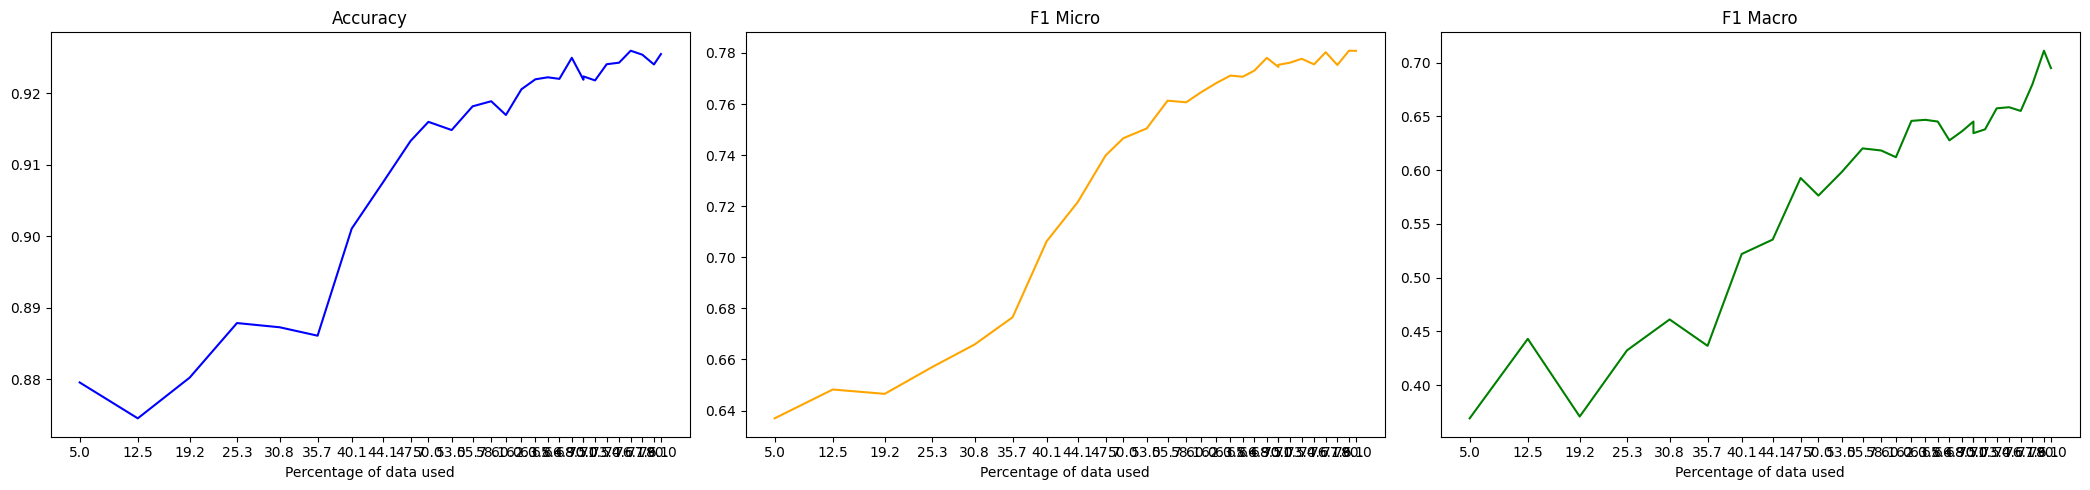

In [24]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5399, Accuracy: 0.8291, F1 Micro: 0.0651, F1 Macro: 0.0219
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4088, Accuracy: 0.8434, F1 Micro: 0.2262, F1 Macro: 0.0788
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3767, Accuracy: 0.8517, F1 Micro: 0.368, F1 Macro: 0.112
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3536, Accuracy: 0.8573, F1 Micro: 0.378, F1 Macro: 0.1366
Epoch 5/10, Train Loss: 0.3178, Accuracy: 0.8614, F1 Micro: 0.3721, F1 Macro: 0.1638
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2987, Accuracy: 0.8739, F1 Micro: 0.5169, F1 Macro: 0.2388
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2704, Accuracy: 0.8759, F1 Micro: 0.5387, F1 Macro: 0.2544
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2407, Accuracy: 0.88, F1 Micro: 0.5818, F1 Macro: 0.2925
Epoch 9/10, Train Loss: 0.2184, Accuracy: 0.8819, F1 Micro: 0.5709, F1 Macro: 0.2969
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3798, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2389, Accuracy: 0.8441, F1 Micro: 0.2827, F1 Macro: 0.0961
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1931, Accuracy: 0.8636, F1 Micro: 0.5425, F1 Macro: 0.2507
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.8689, F1 Micro: 0.5792, F1 Macro: 0.2672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1403, Accuracy: 0.8753, F1 Micro: 0.5795, F1 Macro: 0.2779
Epoch 6/10, Train Loss: 0.1273, Accuracy: 0.8766, F1 Micro: 0.5648, F1 Macro: 0.271
Epoch 7/10, Train Loss: 0.1062, Accuracy: 0.8761, F1 Micro: 0.5642, F1 Macro: 0.273
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0919, Accuracy: 0.8769, F1 Micro: 0.6028, F1 Macro: 0.3312
Epoch 9/10, Train Loss: 0.0769, Accuracy: 0.8782, F1 Micro: 0.5994, F1 Macro: 0.3435
Epoch 10/10, Train Loss: 0.0732, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3035, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1903, Accuracy: 0.857, F1 Micro: 0.4179, F1 Macro: 0.176
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1541, Accuracy: 0.8687, F1 Micro: 0.5496, F1 Macro: 0.2509
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1297, Accuracy: 0.8705, F1 Micro: 0.5842, F1 Macro: 0.2706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1064, Accuracy: 0.8768, F1 Micro: 0.5917, F1 Macro: 0.2804
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.8716, F1 Micro: 0.6187, F1 Macro: 0.351
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.8752, F1 Micro: 0.6176, F1 Macro: 0.3505
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0688, Accuracy: 0.88, F1 Micro: 0.6205, F1 Macro: 0.3815
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.057, Accuracy: 0.8761, F1 Micro: 0.6382, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2842, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1778, Accuracy: 0.8622, F1 Micro: 0.5154, F1 Macro: 0.233
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1449, Accuracy: 0.875, F1 Micro: 0.5459, F1 Macro: 0.2482
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1118, Accuracy: 0.877, F1 Micro: 0.6066, F1 Macro: 0.3078
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0914, Accuracy: 0.8639, F1 Micro: 0.6269, F1 Macro: 0.3213
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0774, Accuracy: 0.8706, F1 Micro: 0.6341, F1 Macro: 0.3959
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.8762, F1 Micro: 0.6393, F1 Macro: 0.4081
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.8868, F1 Micro: 0.6439, F1 Macro: 0.3979
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.8876, F1 Micro: 0.642

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2661, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1786, Accuracy: 0.8637, F1 Micro: 0.4424, F1 Macro: 0.1981
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1469, Accuracy: 0.8677, F1 Micro: 0.4452, F1 Macro: 0.2087
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1125, Accuracy: 0.8776, F1 Micro: 0.6388, F1 Macro: 0.3251
Epoch 5/10, Train Loss: 0.0927, Accuracy: 0.8819, F1 Micro: 0.5804, F1 Macro: 0.3334
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.079, Accuracy: 0.8809, F1 Micro: 0.6589, F1 Macro: 0.3796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0612, Accuracy: 0.8862, F1 Micro: 0.6628, F1 Macro: 0.465
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.8829, F1 Micro: 0.6648, F1 Macro: 0.4387
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0444, Accuracy: 0.8855, F1 Micro: 0.67

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2584, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1849, Accuracy: 0.8562, F1 Micro: 0.3252, F1 Macro: 0.1438
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1442, Accuracy: 0.876, F1 Micro: 0.5272, F1 Macro: 0.2571
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1127, Accuracy: 0.8748, F1 Micro: 0.6689, F1 Macro: 0.445
Epoch 5/10, Train Loss: 0.085, Accuracy: 0.8906, F1 Micro: 0.6453, F1 Macro: 0.4163
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0711, Accuracy: 0.8921, F1 Micro: 0.6689, F1 Macro: 0.4196
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0588, Accuracy: 0.8937, F1 Micro: 0.6834, F1 Macro: 0.4678
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.8941, F1 Micro: 0.67, F1 Macro: 0.4743
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.8932, F1 Micro: 0.6732, F1 Macro: 0.4826
Epoch 10/10, Train Loss: 0.0358, Accuracy: 0.891

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2676, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1844, Accuracy: 0.8774, F1 Micro: 0.5772, F1 Macro: 0.2713
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1436, Accuracy: 0.8876, F1 Micro: 0.6557, F1 Macro: 0.3453
Epoch 4/10, Train Loss: 0.1167, Accuracy: 0.8921, F1 Micro: 0.6409, F1 Macro: 0.3747
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0891, Accuracy: 0.893, F1 Micro: 0.6819, F1 Macro: 0.4617
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.069, Accuracy: 0.8985, F1 Micro: 0.6873, F1 Macro: 0.4634
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0565, Accuracy: 0.8947, F1 Micro: 0.6981, F1 Macro: 0.4715
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0458, Accuracy: 0.8977, F1 Micro: 0.7022, F1 Macro: 0.4879
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.9023, F1 Micro: 0.6966, F1 Macro: 0.4793
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2787, Accuracy: 0.828, F1 Micro: 0.0029, F1 Macro: 0.0013
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1968, Accuracy: 0.8802, F1 Micro: 0.561, F1 Macro: 0.2907
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1517, Accuracy: 0.8954, F1 Micro: 0.6522, F1 Macro: 0.3709
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1179, Accuracy: 0.8986, F1 Micro: 0.7015, F1 Macro: 0.488
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0918, Accuracy: 0.8975, F1 Micro: 0.7031, F1 Macro: 0.4891
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.076, Accuracy: 0.8982, F1 Micro: 0.7164, F1 Macro: 0.5029
Epoch 7/10, Train Loss: 0.0612, Accuracy: 0.9053, F1 Micro: 0.7092, F1 Macro: 0.4941
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9059, F1 Micro: 0.7142, F1 Macro: 0.5021
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.9046, F1 Micro: 0.717, F1 Macro: 0.4993
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2872, Accuracy: 0.847, F1 Micro: 0.2227, F1 Macro: 0.0809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1995, Accuracy: 0.8944, F1 Micro: 0.6722, F1 Macro: 0.4272
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1547, Accuracy: 0.8997, F1 Micro: 0.7017, F1 Macro: 0.4889
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1207, Accuracy: 0.905, F1 Micro: 0.7036, F1 Macro: 0.5226
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0959, Accuracy: 0.9, F1 Micro: 0.7174, F1 Macro: 0.5367
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0736, Accuracy: 0.9089, F1 Micro: 0.7256, F1 Macro: 0.5212
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0591, Accuracy: 0.9097, F1 Micro: 0.7308, F1 Macro: 0.5458
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.9071, F1 Micro: 0.7238, F1 Macro: 0.5453
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9124, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.298, Accuracy: 0.8557, F1 Micro: 0.3462, F1 Macro: 0.1678
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2032, Accuracy: 0.8945, F1 Micro: 0.6392, F1 Macro: 0.4389
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1551, Accuracy: 0.9058, F1 Micro: 0.7176, F1 Macro: 0.5613
Epoch 4/10, Train Loss: 0.1222, Accuracy: 0.9096, F1 Micro: 0.7164, F1 Macro: 0.5621
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0988, Accuracy: 0.9131, F1 Micro: 0.7405, F1 Macro: 0.5804
Epoch 6/10, Train Loss: 0.0735, Accuracy: 0.9147, F1 Micro: 0.7301, F1 Macro: 0.5797
Epoch 7/10, Train Loss: 0.061, Accuracy: 0.9129, F1 Micro: 0.74, F1 Macro: 0.5978
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9077, F1 Micro: 0.7355, F1 Macro: 0.5848
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.9143, F1 Micro: 0.7471, F1 Macro: 0.596
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0377, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3005, Accuracy: 0.8756, F1 Micro: 0.5143, F1 Macro: 0.3228
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1999, Accuracy: 0.9009, F1 Micro: 0.6696, F1 Macro: 0.5063
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1579, Accuracy: 0.9073, F1 Micro: 0.7352, F1 Macro: 0.5822
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1212, Accuracy: 0.9148, F1 Micro: 0.7374, F1 Macro: 0.6001
Epoch 5/10, Train Loss: 0.0974, Accuracy: 0.9149, F1 Micro: 0.7275, F1 Macro: 0.5839
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0779, Accuracy: 0.9134, F1 Micro: 0.7468, F1 Macro: 0.5893
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0626, Accuracy: 0.915, F1 Micro: 0.7527, F1 Macro: 0.6002
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.9162, F1 Micro: 0.7499, F1 Macro: 0.6011
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.9164, F1 Micro: 0.7525, F1 Macro: 0.6042
Epoch 10/10, Train Loss: 0.0393, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3121, Accuracy: 0.8836, F1 Micro: 0.5926, F1 Macro: 0.3738
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.203, Accuracy: 0.9046, F1 Micro: 0.679, F1 Macro: 0.5019
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1571, Accuracy: 0.9124, F1 Micro: 0.7374, F1 Macro: 0.5735
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1224, Accuracy: 0.9178, F1 Micro: 0.7448, F1 Macro: 0.5818
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0993, Accuracy: 0.9169, F1 Micro: 0.7488, F1 Macro: 0.605
Epoch 6/10, Train Loss: 0.0758, Accuracy: 0.9169, F1 Micro: 0.7468, F1 Macro: 0.6033
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0578, Accuracy: 0.9142, F1 Micro: 0.7537, F1 Macro: 0.6036
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9195, F1 Micro: 0.7595, F1 Macro: 0.6133
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.9149, F1 Micro: 0.7546, F1 Macro: 0.6136
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3102, Accuracy: 0.8862, F1 Micro: 0.618, F1 Macro: 0.4169
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2132, Accuracy: 0.9064, F1 Micro: 0.7172, F1 Macro: 0.5705
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1607, Accuracy: 0.9059, F1 Micro: 0.7429, F1 Macro: 0.588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1273, Accuracy: 0.916, F1 Micro: 0.7468, F1 Macro: 0.5917
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.102, Accuracy: 0.919, F1 Micro: 0.7556, F1 Macro: 0.6027
Epoch 6/10, Train Loss: 0.0791, Accuracy: 0.9179, F1 Micro: 0.7489, F1 Macro: 0.6048
Epoch 7/10, Train Loss: 0.0621, Accuracy: 0.914, F1 Micro: 0.7426, F1 Macro: 0.5994
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.9142, F1 Micro: 0.7603, F1 Macro: 0.617
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.9166, F1 Micro: 0.7507, F1 Macro: 0.6088
Epoch 10/10, Train Loss: 0.0382, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.317, Accuracy: 0.8855, F1 Micro: 0.577, F1 Macro: 0.3635
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2079, Accuracy: 0.9057, F1 Micro: 0.7258, F1 Macro: 0.56
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1617, Accuracy: 0.9172, F1 Micro: 0.7547, F1 Macro: 0.6051
Epoch 4/10, Train Loss: 0.1297, Accuracy: 0.9149, F1 Micro: 0.7162, F1 Macro: 0.581
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1026, Accuracy: 0.9191, F1 Micro: 0.7616, F1 Macro: 0.6172
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.082, Accuracy: 0.9206, F1 Micro: 0.7676, F1 Macro: 0.6152
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.9192, F1 Micro: 0.7524, F1 Macro: 0.6161
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9133, F1 Micro: 0.7517, F1 Macro: 0.6093
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0458, Accuracy: 0.9207, F1 Micro: 0.7682, F1 Macro: 0.6338
Epoch 10/10, Train Loss: 0.0368, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3183, Accuracy: 0.8853, F1 Micro: 0.5939, F1 Macro: 0.4367
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2084, Accuracy: 0.9108, F1 Micro: 0.717, F1 Macro: 0.558
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.164, Accuracy: 0.9183, F1 Micro: 0.7456, F1 Macro: 0.5949
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1339, Accuracy: 0.9191, F1 Micro: 0.7524, F1 Macro: 0.6064
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1073, Accuracy: 0.9204, F1 Micro: 0.7537, F1 Macro: 0.6069
Epoch 6/10, Train Loss: 0.0835, Accuracy: 0.9164, F1 Micro: 0.7532, F1 Macro: 0.6106
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.921, F1 Micro: 0.7515, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9207, F1 Micro: 0.7643, F1 Macro: 0.6251
Epoch 9/10, Train Loss: 0.0442, Accuracy: 0.9128, F1 Micro: 0.7491, F1 Macro: 0.6165
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3231, Accuracy: 0.89, F1 Micro: 0.6001, F1 Macro: 0.3919
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.217, Accuracy: 0.9093, F1 Micro: 0.6958, F1 Macro: 0.5284
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1671, Accuracy: 0.9211, F1 Micro: 0.7501, F1 Macro: 0.5976
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1295, Accuracy: 0.9189, F1 Micro: 0.7649, F1 Macro: 0.6165
Epoch 5/10, Train Loss: 0.1019, Accuracy: 0.9203, F1 Micro: 0.7618, F1 Macro: 0.6242
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0814, Accuracy: 0.9203, F1 Micro: 0.7656, F1 Macro: 0.6181
Epoch 7/10, Train Loss: 0.0646, Accuracy: 0.9195, F1 Micro: 0.7557, F1 Macro: 0.6098
Epoch 8/10, Train Loss: 0.0504, Accuracy: 0.9179, F1 Micro: 0.7648, F1 Macro: 0.6212
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.9189, F1 Micro: 0.7454, F1 Macro: 0.6292
Epoch 10/10, Train Loss: 0.0409, Accuracy: 0.9196, F1 Micro: 0.7572, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3201, Accuracy: 0.8943, F1 Micro: 0.637, F1 Macro: 0.3924
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2119, Accuracy: 0.9133, F1 Micro: 0.7178, F1 Macro: 0.5472
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1627, Accuracy: 0.9133, F1 Micro: 0.7577, F1 Macro: 0.6055
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1301, Accuracy: 0.9218, F1 Micro: 0.7732, F1 Macro: 0.623
Epoch 5/10, Train Loss: 0.1032, Accuracy: 0.9201, F1 Micro: 0.7633, F1 Macro: 0.6105
Epoch 6/10, Train Loss: 0.0835, Accuracy: 0.9194, F1 Micro: 0.7692, F1 Macro: 0.624
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.9204, F1 Micro: 0.7567, F1 Macro: 0.6276
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.914, F1 Micro: 0.7583, F1 Macro: 0.613
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.921, F1 Micro: 0.7609, F1 Macro: 0.6483
Epoch 10/10, Train Loss: 0.0414, Accuracy: 0.9189, F1 Micro: 0.7604, F1 Macro: 0.6383
Iteration 8616: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3206, Accuracy: 0.8906, F1 Micro: 0.596, F1 Macro: 0.3844
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2112, Accuracy: 0.9106, F1 Micro: 0.74, F1 Macro: 0.5831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1627, Accuracy: 0.9197, F1 Micro: 0.7559, F1 Macro: 0.604
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1308, Accuracy: 0.9218, F1 Micro: 0.76, F1 Macro: 0.6169
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1033, Accuracy: 0.9232, F1 Micro: 0.773, F1 Macro: 0.6279
Epoch 6/10, Train Loss: 0.084, Accuracy: 0.9173, F1 Micro: 0.7458, F1 Macro: 0.6123
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.9222, F1 Micro: 0.7582, F1 Macro: 0.6332
Epoch 8/10, Train Loss: 0.055, Accuracy: 0.9199, F1 Micro: 0.7653, F1 Macro: 0.6309
Epoch 9/10, Train Loss: 0.048, Accuracy: 0.9214, F1 Micro: 0.7665, F1 Macro: 0.6408
Epoch 10/10, Train Loss: 0.0388, Accuracy: 0.9212, F1 Micro: 0.7657, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.317, Accuracy: 0.8981, F1 Micro: 0.657, F1 Macro: 0.427
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2115, Accuracy: 0.9118, F1 Micro: 0.7432, F1 Macro: 0.5828
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1619, Accuracy: 0.9203, F1 Micro: 0.7574, F1 Macro: 0.6009
Epoch 4/10, Train Loss: 0.1349, Accuracy: 0.9211, F1 Micro: 0.7484, F1 Macro: 0.5934
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1053, Accuracy: 0.9228, F1 Micro: 0.7686, F1 Macro: 0.629
Epoch 6/10, Train Loss: 0.0835, Accuracy: 0.9204, F1 Micro: 0.7613, F1 Macro: 0.6348
Epoch 7/10, Train Loss: 0.067, Accuracy: 0.9204, F1 Micro: 0.7628, F1 Macro: 0.6529
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.9205, F1 Micro: 0.7655, F1 Macro: 0.6344
Epoch 9/10, Train Loss: 0.0469, Accuracy: 0.9227, F1 Micro: 0.767, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0417, Accuracy: 0.9216, F1 Micro: 0.7689, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3176, Accuracy: 0.8956, F1 Micro: 0.6457, F1 Macro: 0.3872
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2084, Accuracy: 0.9164, F1 Micro: 0.7405, F1 Macro: 0.5892
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.163, Accuracy: 0.9231, F1 Micro: 0.7677, F1 Macro: 0.6183
Epoch 4/10, Train Loss: 0.1331, Accuracy: 0.9225, F1 Micro: 0.7633, F1 Macro: 0.6148
Epoch 5/10, Train Loss: 0.1061, Accuracy: 0.9153, F1 Micro: 0.7648, F1 Macro: 0.6264
Epoch 6/10, Train Loss: 0.0843, Accuracy: 0.9221, F1 Micro: 0.7638, F1 Macro: 0.6285
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.9219, F1 Micro: 0.7673, F1 Macro: 0.6455
Epoch 8/10, Train Loss: 0.0555, Accuracy: 0.9214, F1 Micro: 0.7676, F1 Macro: 0.6665
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.9202, F1 Micro: 0.766, F1 Macro: 0.6499
Epoch 10/10, Train Loss: 0.0385, Accuracy: 0.9229, F1 Micro: 0.7623, F1 Macro: 0.6384
Iteration 9216: Accuracy: 0.9231, F1 Micro: 0.7677, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3226, Accuracy: 0.8967, F1 Micro: 0.6347, F1 Macro: 0.4439
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2117, Accuracy: 0.9112, F1 Micro: 0.7409, F1 Macro: 0.5742
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.16, Accuracy: 0.917, F1 Micro: 0.7591, F1 Macro: 0.6116
Epoch 4/10, Train Loss: 0.1313, Accuracy: 0.9225, F1 Micro: 0.7544, F1 Macro: 0.6108
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.9231, F1 Micro: 0.7768, F1 Macro: 0.633
Epoch 6/10, Train Loss: 0.0852, Accuracy: 0.9204, F1 Micro: 0.7703, F1 Macro: 0.6527
Epoch 7/10, Train Loss: 0.0703, Accuracy: 0.9213, F1 Micro: 0.7724, F1 Macro: 0.6521
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.9202, F1 Micro: 0.7698, F1 Macro: 0.6528
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.9177, F1 Micro: 0.7677, F1 Macro: 0.6523
Epoch 10/10, Train Loss: 0.0434, Accuracy: 0.9203, F1 Micro: 0.7668, F1 Macro: 0.6559
Iteration 9218: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3203, Accuracy: 0.8914, F1 Micro: 0.7019, F1 Macro: 0.5114
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2056, Accuracy: 0.9151, F1 Micro: 0.7475, F1 Macro: 0.5935
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.165, Accuracy: 0.9201, F1 Micro: 0.7604, F1 Macro: 0.6201
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1296, Accuracy: 0.9235, F1 Micro: 0.7743, F1 Macro: 0.6317
Epoch 5/10, Train Loss: 0.106, Accuracy: 0.9215, F1 Micro: 0.7671, F1 Macro: 0.6264
Epoch 6/10, Train Loss: 0.0866, Accuracy: 0.9226, F1 Micro: 0.7643, F1 Macro: 0.6193
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.9219, F1 Micro: 0.7601, F1 Macro: 0.6308
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9156, F1 Micro: 0.7617, F1 Macro: 0.6483
Epoch 9/10, Train Loss: 0.0469, Accuracy: 0.9186, F1 Micro: 0.767, F1 Macro: 0.6574
Epoch 10/10, Train Loss: 0.0431, Accuracy: 0.9217, F1 Micro: 0.7621, F1 Macro: 0.6505
Iteration 9418: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3204, Accuracy: 0.8985, F1 Micro: 0.6694, F1 Macro: 0.4541
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2083, Accuracy: 0.9178, F1 Micro: 0.7404, F1 Macro: 0.595
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1658, Accuracy: 0.921, F1 Micro: 0.76, F1 Macro: 0.6101
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1327, Accuracy: 0.923, F1 Micro: 0.7743, F1 Macro: 0.627
Epoch 5/10, Train Loss: 0.1029, Accuracy: 0.9236, F1 Micro: 0.7698, F1 Macro: 0.6347
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0854, Accuracy: 0.9225, F1 Micro: 0.7753, F1 Macro: 0.6498
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.9196, F1 Micro: 0.7741, F1 Macro: 0.6628
Epoch 8/10, Train Loss: 0.0565, Accuracy: 0.9213, F1 Micro: 0.7689, F1 Macro: 0.6431
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.9198, F1 Micro: 0.7723, F1 Macro: 0.6565
Epoch 10/10, Train Loss: 0.0388, Accuracy: 0.9208, F1 Micro: 0.766, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3181, Accuracy: 0.8992, F1 Micro: 0.6527, F1 Macro: 0.4108
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2115, Accuracy: 0.9167, F1 Micro: 0.7485, F1 Macro: 0.586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.166, Accuracy: 0.9192, F1 Micro: 0.7626, F1 Macro: 0.6011
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1331, Accuracy: 0.9209, F1 Micro: 0.7698, F1 Macro: 0.6227
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1025, Accuracy: 0.9232, F1 Micro: 0.7736, F1 Macro: 0.6393
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.922, F1 Micro: 0.7771, F1 Macro: 0.6581
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.9203, F1 Micro: 0.7684, F1 Macro: 0.6599
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.9204, F1 Micro: 0.7732, F1 Macro: 0.6704
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9217, F1 Micro: 0.7688, F1 Macro: 0.6766
Epoch 10/10, Train Loss: 0.0407, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3227, Accuracy: 0.8997, F1 Micro: 0.7012, F1 Macro: 0.4877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2155, Accuracy: 0.914, F1 Micro: 0.7459, F1 Macro: 0.5812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1652, Accuracy: 0.92, F1 Micro: 0.768, F1 Macro: 0.6164
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.133, Accuracy: 0.9188, F1 Micro: 0.7707, F1 Macro: 0.6421
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1087, Accuracy: 0.9259, F1 Micro: 0.7725, F1 Macro: 0.6584
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9256, F1 Micro: 0.776, F1 Macro: 0.658
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.9249, F1 Micro: 0.7771, F1 Macro: 0.6787
Epoch 8/10, Train Loss: 0.0572, Accuracy: 0.923, F1 Micro: 0.7751, F1 Macro: 0.6934
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.9183, F1 Micro: 0.7656, F1 Macro: 0.6901
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3178, Accuracy: 0.9012, F1 Micro: 0.6636, F1 Macro: 0.4581
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2123, Accuracy: 0.9163, F1 Micro: 0.7327, F1 Macro: 0.5678
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1672, Accuracy: 0.9141, F1 Micro: 0.7616, F1 Macro: 0.6135
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.134, Accuracy: 0.9236, F1 Micro: 0.7764, F1 Macro: 0.6479
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.103, Accuracy: 0.9267, F1 Micro: 0.7773, F1 Macro: 0.6653
Epoch 6/10, Train Loss: 0.0848, Accuracy: 0.9239, F1 Micro: 0.7762, F1 Macro: 0.6867
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.9192, F1 Micro: 0.7684, F1 Macro: 0.6639
Epoch 8/10, Train Loss: 0.0584, Accuracy: 0.917, F1 Micro: 0.7655, F1 Macro: 0.6767
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9223, F1 Micro: 0.7672, F1 Macro: 0.6862
Epoch 10/10, Train Loss: 0.0382, Accuracy: 0.9227, F1 Micro: 0.7746, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3159, Accuracy: 0.9029, F1 Micro: 0.6977, F1 Macro: 0.4996
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2126, Accuracy: 0.9185, F1 Micro: 0.7451, F1 Macro: 0.5799
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1628, Accuracy: 0.9192, F1 Micro: 0.7579, F1 Macro: 0.6182
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1372, Accuracy: 0.9239, F1 Micro: 0.77, F1 Macro: 0.6473
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.11, Accuracy: 0.9237, F1 Micro: 0.7779, F1 Macro: 0.6723
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.9209, F1 Micro: 0.776, F1 Macro: 0.7033
Epoch 7/10, Train Loss: 0.0698, Accuracy: 0.9186, F1 Micro: 0.7748, F1 Macro: 0.7072
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9262, F1 Micro: 0.7718, F1 Macro: 0.6995
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9222, F1 Micro: 0.7788, F1 Macro: 0.7043
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3192, Accuracy: 0.903, F1 Micro: 0.6966, F1 Macro: 0.4648
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2184, Accuracy: 0.9178, F1 Micro: 0.7519, F1 Macro: 0.5906
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1726, Accuracy: 0.9218, F1 Micro: 0.7734, F1 Macro: 0.6648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.134, Accuracy: 0.9228, F1 Micro: 0.7757, F1 Macro: 0.6586
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.9277, F1 Micro: 0.7796, F1 Macro: 0.6903
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0839, Accuracy: 0.9229, F1 Micro: 0.7809, F1 Macro: 0.7002
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0691, Accuracy: 0.9261, F1 Micro: 0.7829, F1 Macro: 0.7183
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9245, F1 Micro: 0.7815, F1 Macro: 0.7098
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9233, F1 Micro: 0.7762, F1 Macro: 0.7063
Epoch 

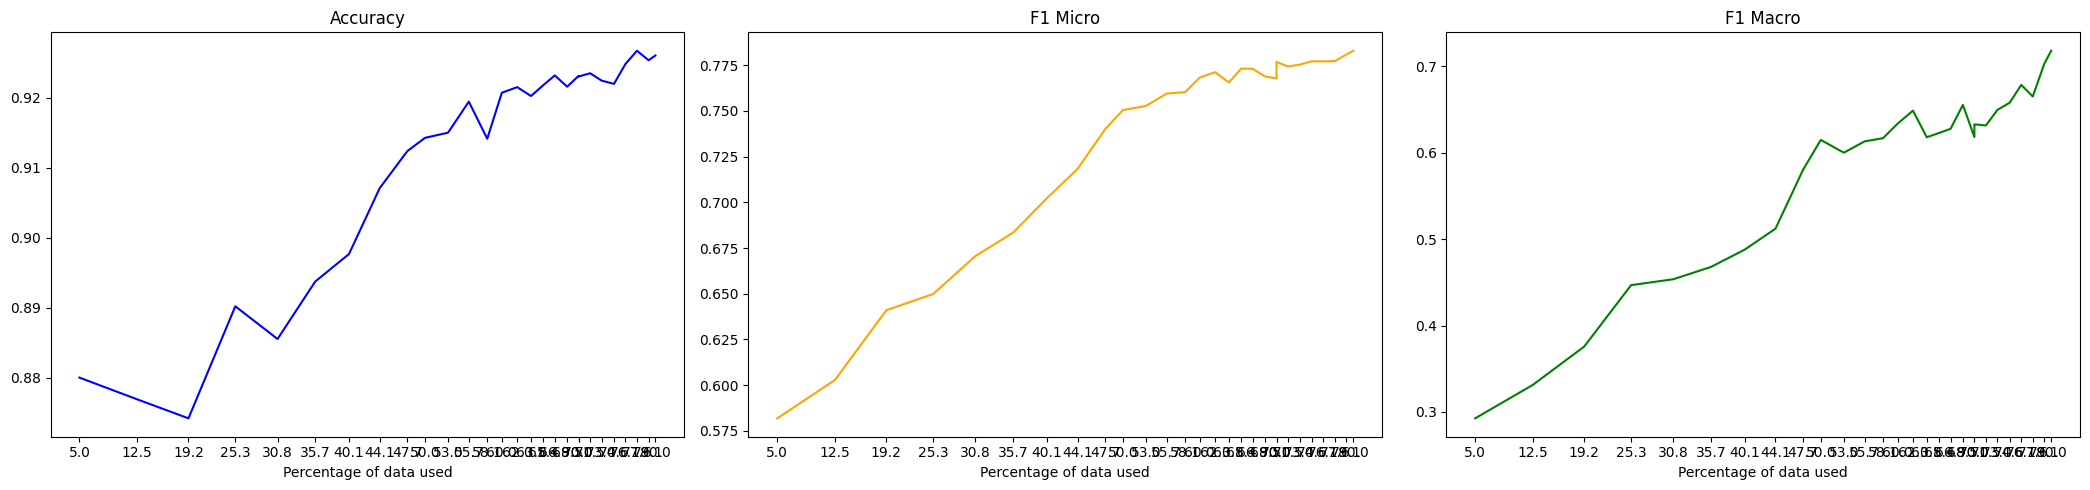

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5567, Accuracy: 0.8289, F1 Micro: 0.0251, F1 Macro: 0.0108
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4193, Accuracy: 0.8313, F1 Micro: 0.0519, F1 Macro: 0.0212
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3788, Accuracy: 0.8462, F1 Micro: 0.2489, F1 Macro: 0.0856
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.341, Accuracy: 0.8645, F1 Micro: 0.4617, F1 Macro: 0.1803
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.31, Accuracy: 0.8684, F1 Micro: 0.5935, F1 Macro: 0.2754
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2914, Accuracy: 0.8655, F1 Micro: 0.6095, F1 Macro: 0.2934
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2715, Accuracy: 0.8748, F1 Micro: 0.6182, F1 Macro: 0.3125
Epoch 8/10, Train Loss: 0.2369, Accuracy: 0.88, F1 Micro: 0.6029, F1 Macro: 0.3139
Epoch 9/10, Train Loss: 0.2079, Accuracy: 0.8819, F1 Micro: 0.6044, F1 Macro: 0.3656
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3874, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2365, Accuracy: 0.8414, F1 Micro: 0.2058, F1 Macro: 0.0732
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.8626, F1 Micro: 0.463, F1 Macro: 0.2148
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.8606, F1 Micro: 0.5977, F1 Macro: 0.2758
Epoch 5/10, Train Loss: 0.1456, Accuracy: 0.8732, F1 Micro: 0.5655, F1 Macro: 0.2813
Epoch 6/10, Train Loss: 0.1178, Accuracy: 0.8752, F1 Micro: 0.5497, F1 Macro: 0.2786
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1162, Accuracy: 0.8783, F1 Micro: 0.6191, F1 Macro: 0.3307
Epoch 8/10, Train Loss: 0.092, Accuracy: 0.8811, F1 Micro: 0.619, F1 Macro: 0.3433
Epoch 9/10, Train Loss: 0.0793, Accuracy: 0.884, F1 Micro: 0.6163, F1 Macro: 0.3808
Epoch 10/10, Train Loss: 0.0775, Accuracy: 0.884, F1 Micro: 0.6071, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3194, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1952, Accuracy: 0.8529, F1 Micro: 0.3836, F1 Macro: 0.1494
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1512, Accuracy: 0.8628, F1 Micro: 0.4125, F1 Macro: 0.1782
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1283, Accuracy: 0.8712, F1 Micro: 0.5952, F1 Macro: 0.2769
Epoch 5/10, Train Loss: 0.1071, Accuracy: 0.8752, F1 Micro: 0.576, F1 Macro: 0.3035
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.8778, F1 Micro: 0.6268, F1 Macro: 0.3362
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.8819, F1 Micro: 0.6386, F1 Macro: 0.3763
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.8822, F1 Micro: 0.6378, F1 Macro: 0.3991
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0588, Accuracy: 0.8819, F1 Micro: 0.6611, F1 Macro: 0.4216
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.283, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1825, Accuracy: 0.8562, F1 Micro: 0.358, F1 Macro: 0.1622
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1295, Accuracy: 0.861, F1 Micro: 0.6035, F1 Macro: 0.2785
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1199, Accuracy: 0.877, F1 Micro: 0.6072, F1 Macro: 0.2879
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0892, Accuracy: 0.8755, F1 Micro: 0.6218, F1 Macro: 0.3164
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0773, Accuracy: 0.8796, F1 Micro: 0.6264, F1 Macro: 0.3372
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.8698, F1 Micro: 0.6525, F1 Macro: 0.4355
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.8752, F1 Micro: 0.6475, F1 Macro: 0.441
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.045, Accuracy: 0.8826, F1 Micro: 0.6611, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2641, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1721, Accuracy: 0.8627, F1 Micro: 0.5356, F1 Macro: 0.2479
Epoch 3/10, Train Loss: 0.1388, Accuracy: 0.8726, F1 Micro: 0.4824, F1 Macro: 0.2037
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1139, Accuracy: 0.8767, F1 Micro: 0.5546, F1 Macro: 0.2685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0907, Accuracy: 0.8738, F1 Micro: 0.6396, F1 Macro: 0.3792
Epoch 6/10, Train Loss: 0.0697, Accuracy: 0.8813, F1 Micro: 0.6333, F1 Macro: 0.4063
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0567, Accuracy: 0.8777, F1 Micro: 0.6431, F1 Macro: 0.4398
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.8874, F1 Micro: 0.6295, F1 Macro: 0.3523
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.8886, F1 Micro: 0.6655, F1 Macro: 0.4525
Higher F1 achieved, saving model
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2715, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1758, Accuracy: 0.8666, F1 Micro: 0.5658, F1 Macro: 0.2681
Epoch 3/10, Train Loss: 0.1446, Accuracy: 0.8723, F1 Micro: 0.4685, F1 Macro: 0.2072
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.128, Accuracy: 0.8831, F1 Micro: 0.6328, F1 Macro: 0.3201
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0981, Accuracy: 0.8871, F1 Micro: 0.6503, F1 Macro: 0.3966
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0739, Accuracy: 0.8889, F1 Micro: 0.6738, F1 Macro: 0.4547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0592, Accuracy: 0.8884, F1 Micro: 0.6768, F1 Macro: 0.4106
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0497, Accuracy: 0.8905, F1 Micro: 0.6823, F1 Macro: 0.4623
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.8961, F1 Micro: 0.6739, F1 Macro: 0.4551
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2739, Accuracy: 0.8278, F1 Micro: 0.0007, F1 Macro: 0.0003
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1873, Accuracy: 0.8744, F1 Micro: 0.5028, F1 Macro: 0.2351
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1471, Accuracy: 0.8871, F1 Micro: 0.6466, F1 Macro: 0.3382
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.115, Accuracy: 0.889, F1 Micro: 0.6787, F1 Macro: 0.452
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0887, Accuracy: 0.8926, F1 Micro: 0.6898, F1 Macro: 0.474
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0757, Accuracy: 0.8983, F1 Micro: 0.6942, F1 Macro: 0.4714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0608, Accuracy: 0.8993, F1 Micro: 0.7004, F1 Macro: 0.4653
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9016, F1 Micro: 0.7022, F1 Macro: 0.4874
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2845, Accuracy: 0.8307, F1 Micro: 0.036, F1 Macro: 0.0154
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1964, Accuracy: 0.8796, F1 Micro: 0.5319, F1 Macro: 0.2452
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1507, Accuracy: 0.8923, F1 Micro: 0.6551, F1 Macro: 0.3745
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1201, Accuracy: 0.8892, F1 Micro: 0.6988, F1 Macro: 0.4926
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0965, Accuracy: 0.9, F1 Micro: 0.7066, F1 Macro: 0.5177
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0702, Accuracy: 0.9055, F1 Micro: 0.7142, F1 Macro: 0.514
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.9057, F1 Micro: 0.7262, F1 Macro: 0.5475
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.9086, F1 Micro: 0.7112, F1 Macro: 0.5068
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.91, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2922, Accuracy: 0.8514, F1 Micro: 0.3113, F1 Macro: 0.1375
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.199, Accuracy: 0.8945, F1 Micro: 0.6494, F1 Macro: 0.4493
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1575, Accuracy: 0.8949, F1 Micro: 0.716, F1 Macro: 0.5532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1216, Accuracy: 0.9025, F1 Micro: 0.7186, F1 Macro: 0.543
Epoch 5/10, Train Loss: 0.0949, Accuracy: 0.9089, F1 Micro: 0.6987, F1 Macro: 0.5166
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0765, Accuracy: 0.9089, F1 Micro: 0.7391, F1 Macro: 0.5784
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.9077, F1 Micro: 0.7133, F1 Macro: 0.5688
Epoch 8/10, Train Loss: 0.054, Accuracy: 0.9123, F1 Micro: 0.7363, F1 Macro: 0.5772
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9086, F1 Micro: 0.7425, F1 Macro: 0.6009
Epoch 10/10, Train Loss: 0.0385, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.313, Accuracy: 0.865, F1 Micro: 0.422, F1 Macro: 0.2111
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1999, Accuracy: 0.8949, F1 Micro: 0.6204, F1 Macro: 0.4285
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1523, Accuracy: 0.9064, F1 Micro: 0.6933, F1 Macro: 0.5125
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.125, Accuracy: 0.9088, F1 Micro: 0.7265, F1 Macro: 0.5699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1012, Accuracy: 0.9088, F1 Micro: 0.732, F1 Macro: 0.5894
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0826, Accuracy: 0.9124, F1 Micro: 0.7396, F1 Macro: 0.5875
Epoch 7/10, Train Loss: 0.0641, Accuracy: 0.9129, F1 Micro: 0.7328, F1 Macro: 0.5951
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.054, Accuracy: 0.914, F1 Micro: 0.7473, F1 Macro: 0.5971
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9137, F1 Micro: 0.7438, F1 Macro: 0.6041
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3092, Accuracy: 0.8695, F1 Micro: 0.4619, F1 Macro: 0.2972
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2048, Accuracy: 0.8992, F1 Micro: 0.644, F1 Macro: 0.4607
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1584, Accuracy: 0.9097, F1 Micro: 0.7115, F1 Macro: 0.5699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1259, Accuracy: 0.9132, F1 Micro: 0.7417, F1 Macro: 0.5905
Epoch 5/10, Train Loss: 0.0948, Accuracy: 0.9069, F1 Micro: 0.7409, F1 Macro: 0.5916
Epoch 6/10, Train Loss: 0.0809, Accuracy: 0.9129, F1 Micro: 0.7081, F1 Macro: 0.5605
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0645, Accuracy: 0.9161, F1 Micro: 0.7422, F1 Macro: 0.5843
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.9128, F1 Micro: 0.7493, F1 Macro: 0.6026
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9149, F1 Micro: 0.746, F1 Macro: 0.6044
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3215, Accuracy: 0.8641, F1 Micro: 0.3863, F1 Macro: 0.1949
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2102, Accuracy: 0.9012, F1 Micro: 0.6634, F1 Macro: 0.5075
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1617, Accuracy: 0.9123, F1 Micro: 0.7323, F1 Macro: 0.5859
Epoch 4/10, Train Loss: 0.1282, Accuracy: 0.9147, F1 Micro: 0.7287, F1 Macro: 0.5613
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0992, Accuracy: 0.9123, F1 Micro: 0.7467, F1 Macro: 0.5889
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0779, Accuracy: 0.9177, F1 Micro: 0.754, F1 Macro: 0.6088
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.9174, F1 Micro: 0.7414, F1 Macro: 0.6038
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9169, F1 Micro: 0.7503, F1 Macro: 0.6017
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.9174, F1 Micro: 0.7517, F1 Macro: 0.6076
Epoch 10/10, Train Loss: 0.0369, Accuracy: 0.9175, F1 Micro: 0.7497, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3196, Accuracy: 0.8869, F1 Micro: 0.5962, F1 Macro: 0.3812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2121, Accuracy: 0.9009, F1 Micro: 0.6875, F1 Macro: 0.5454
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1635, Accuracy: 0.9152, F1 Micro: 0.7246, F1 Macro: 0.5793
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1286, Accuracy: 0.911, F1 Micro: 0.7513, F1 Macro: 0.6119
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0959, Accuracy: 0.913, F1 Micro: 0.7535, F1 Macro: 0.6115
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0794, Accuracy: 0.9202, F1 Micro: 0.7643, F1 Macro: 0.6155
Epoch 7/10, Train Loss: 0.0641, Accuracy: 0.9206, F1 Micro: 0.7558, F1 Macro: 0.6063
Epoch 8/10, Train Loss: 0.0504, Accuracy: 0.92, F1 Micro: 0.7589, F1 Macro: 0.6177
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9206, F1 Micro: 0.7585, F1 Macro: 0.611
Epoch 10/10, Train Loss: 0.0402, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3221, Accuracy: 0.8865, F1 Micro: 0.5876, F1 Macro: 0.3667
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2096, Accuracy: 0.9047, F1 Micro: 0.6721, F1 Macro: 0.5134
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1648, Accuracy: 0.9154, F1 Micro: 0.7348, F1 Macro: 0.5959
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1283, Accuracy: 0.917, F1 Micro: 0.7576, F1 Macro: 0.6159
Epoch 5/10, Train Loss: 0.0976, Accuracy: 0.9179, F1 Micro: 0.7574, F1 Macro: 0.6169
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0828, Accuracy: 0.9163, F1 Micro: 0.7596, F1 Macro: 0.6092
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.9136, F1 Micro: 0.7398, F1 Macro: 0.6013
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.9216, F1 Micro: 0.7684, F1 Macro: 0.6257
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.9235, F1 Micro: 0.7733, F1 Macro: 0.6443
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.323, Accuracy: 0.8847, F1 Micro: 0.5528, F1 Macro: 0.3314
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2106, Accuracy: 0.909, F1 Micro: 0.7214, F1 Macro: 0.5539
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1631, Accuracy: 0.9157, F1 Micro: 0.7553, F1 Macro: 0.6046
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1374, Accuracy: 0.9233, F1 Micro: 0.7608, F1 Macro: 0.6128
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1015, Accuracy: 0.9155, F1 Micro: 0.7633, F1 Macro: 0.6211
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0823, Accuracy: 0.922, F1 Micro: 0.7654, F1 Macro: 0.6218
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.9219, F1 Micro: 0.7667, F1 Macro: 0.6277
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0566, Accuracy: 0.9235, F1 Micro: 0.7723, F1 Macro: 0.6209
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3244, Accuracy: 0.8906, F1 Micro: 0.6032, F1 Macro: 0.4133
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2157, Accuracy: 0.9123, F1 Micro: 0.7303, F1 Macro: 0.5557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1687, Accuracy: 0.9192, F1 Micro: 0.7493, F1 Macro: 0.6015
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1311, Accuracy: 0.9209, F1 Micro: 0.7584, F1 Macro: 0.6171
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1013, Accuracy: 0.9229, F1 Micro: 0.7631, F1 Macro: 0.6169
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0829, Accuracy: 0.9242, F1 Micro: 0.7643, F1 Macro: 0.6188
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.067, Accuracy: 0.9173, F1 Micro: 0.7685, F1 Macro: 0.6272
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9214, F1 Micro: 0.7693, F1 Macro: 0.625
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9208, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3292, Accuracy: 0.8899, F1 Micro: 0.6056, F1 Macro: 0.3939
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2168, Accuracy: 0.9115, F1 Micro: 0.722, F1 Macro: 0.5503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1639, Accuracy: 0.921, F1 Micro: 0.7515, F1 Macro: 0.602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1333, Accuracy: 0.9215, F1 Micro: 0.7701, F1 Macro: 0.6161
Epoch 5/10, Train Loss: 0.1066, Accuracy: 0.9223, F1 Micro: 0.7676, F1 Macro: 0.6114
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9217, F1 Micro: 0.7633, F1 Macro: 0.6135
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9195, F1 Micro: 0.7696, F1 Macro: 0.6358
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9259, F1 Micro: 0.777, F1 Macro: 0.6527
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.9193, F1 Micro: 0.7705, F1 Macro: 0.655
Epoch 10/10, Train Loss: 0.0388, Accuracy: 0.9203, F1 Micro: 0.7686, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3242, Accuracy: 0.8925, F1 Micro: 0.6893, F1 Macro: 0.4679
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2144, Accuracy: 0.9075, F1 Micro: 0.725, F1 Macro: 0.5354
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1702, Accuracy: 0.9184, F1 Micro: 0.7672, F1 Macro: 0.6247
Epoch 4/10, Train Loss: 0.1337, Accuracy: 0.9217, F1 Micro: 0.7625, F1 Macro: 0.6151
Epoch 5/10, Train Loss: 0.1046, Accuracy: 0.9186, F1 Micro: 0.7629, F1 Macro: 0.6206
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0838, Accuracy: 0.92, F1 Micro: 0.77, F1 Macro: 0.621
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.9244, F1 Micro: 0.7725, F1 Macro: 0.6463
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0569, Accuracy: 0.925, F1 Micro: 0.7746, F1 Macro: 0.6355
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.9241, F1 Micro: 0.7702, F1 Macro: 0.6542
Epoch 10/10, Train Loss: 0.0385, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.326, Accuracy: 0.8978, F1 Micro: 0.6672, F1 Macro: 0.4494
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2125, Accuracy: 0.9094, F1 Micro: 0.7315, F1 Macro: 0.5565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.164, Accuracy: 0.9197, F1 Micro: 0.7594, F1 Macro: 0.6063
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.134, Accuracy: 0.9217, F1 Micro: 0.7599, F1 Macro: 0.6161
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1053, Accuracy: 0.923, F1 Micro: 0.7702, F1 Macro: 0.6198
Epoch 6/10, Train Loss: 0.0859, Accuracy: 0.9214, F1 Micro: 0.7669, F1 Macro: 0.6181
Epoch 7/10, Train Loss: 0.0679, Accuracy: 0.9229, F1 Micro: 0.7699, F1 Macro: 0.6492
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.923, F1 Micro: 0.7692, F1 Macro: 0.6412
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9254, F1 Micro: 0.7746, F1 Macro: 0.6652
Epoch 10/10, Train Loss: 0.0402, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3225, Accuracy: 0.899, F1 Micro: 0.6698, F1 Macro: 0.4414
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2062, Accuracy: 0.915, F1 Micro: 0.7417, F1 Macro: 0.5567
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1659, Accuracy: 0.9169, F1 Micro: 0.7519, F1 Macro: 0.6072
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1329, Accuracy: 0.9229, F1 Micro: 0.771, F1 Macro: 0.6187
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1052, Accuracy: 0.9186, F1 Micro: 0.7726, F1 Macro: 0.6258
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.9212, F1 Micro: 0.7703, F1 Macro: 0.6409
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9215, F1 Micro: 0.7768, F1 Macro: 0.6462
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.9222, F1 Micro: 0.7655, F1 Macro: 0.6568
Epoch 9/10, Train Loss: 0.0462, Accuracy: 0.9216, F1 Micro: 0.7684, F1 Macro: 0.6808
Epoch 10/10, Train Loss: 0.0408, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3213, Accuracy: 0.8994, F1 Micro: 0.6777, F1 Macro: 0.4763
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2104, Accuracy: 0.9013, F1 Micro: 0.7373, F1 Macro: 0.5815
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1648, Accuracy: 0.9186, F1 Micro: 0.7446, F1 Macro: 0.5957
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1328, Accuracy: 0.924, F1 Micro: 0.7661, F1 Macro: 0.6161
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1059, Accuracy: 0.9251, F1 Micro: 0.7764, F1 Macro: 0.6324
Epoch 6/10, Train Loss: 0.0819, Accuracy: 0.9247, F1 Micro: 0.7709, F1 Macro: 0.6388
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.9237, F1 Micro: 0.7683, F1 Macro: 0.641
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0553, Accuracy: 0.9248, F1 Micro: 0.7791, F1 Macro: 0.6555
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.9237, F1 Micro: 0.7666, F1 Macro: 0.6599
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3261, Accuracy: 0.8978, F1 Micro: 0.6631, F1 Macro: 0.4048
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2115, Accuracy: 0.9113, F1 Micro: 0.7438, F1 Macro: 0.5802
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1704, Accuracy: 0.9192, F1 Micro: 0.7625, F1 Macro: 0.6026
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.131, Accuracy: 0.9238, F1 Micro: 0.7704, F1 Macro: 0.6171
Epoch 5/10, Train Loss: 0.1042, Accuracy: 0.9192, F1 Micro: 0.7691, F1 Macro: 0.6194
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0854, Accuracy: 0.9256, F1 Micro: 0.778, F1 Macro: 0.6488
Epoch 7/10, Train Loss: 0.0661, Accuracy: 0.9218, F1 Micro: 0.7722, F1 Macro: 0.6584
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.9204, F1 Micro: 0.7735, F1 Macro: 0.681
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.9217, F1 Micro: 0.771, F1 Macro: 0.6859
Epoch 10/10, Train Loss: 0.0421, Accuracy: 0.923, F1 Micro: 0.7748, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3252, Accuracy: 0.897, F1 Micro: 0.7, F1 Macro: 0.4821
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2114, Accuracy: 0.9141, F1 Micro: 0.7442, F1 Macro: 0.5878
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1615, Accuracy: 0.9199, F1 Micro: 0.7616, F1 Macro: 0.6181
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1309, Accuracy: 0.9155, F1 Micro: 0.7653, F1 Macro: 0.622
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.108, Accuracy: 0.9224, F1 Micro: 0.7778, F1 Macro: 0.6492
Epoch 6/10, Train Loss: 0.0839, Accuracy: 0.9205, F1 Micro: 0.773, F1 Macro: 0.6511
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.9243, F1 Micro: 0.7782, F1 Macro: 0.67
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.9231, F1 Micro: 0.7659, F1 Macro: 0.6662
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9232, F1 Micro: 0.7769, F1 Macro: 0.6808
Epoch 10/10, Train Loss: 0.0401, Accuracy: 0.92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3231, Accuracy: 0.9027, F1 Micro: 0.6956, F1 Macro: 0.4778
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2116, Accuracy: 0.9157, F1 Micro: 0.7412, F1 Macro: 0.5688
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1695, Accuracy: 0.9219, F1 Micro: 0.7561, F1 Macro: 0.5986
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1385, Accuracy: 0.9223, F1 Micro: 0.7651, F1 Macro: 0.6321
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1063, Accuracy: 0.9211, F1 Micro: 0.7759, F1 Macro: 0.6347
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9208, F1 Micro: 0.7714, F1 Macro: 0.6515
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.9222, F1 Micro: 0.7726, F1 Macro: 0.6613
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9216, F1 Micro: 0.7736, F1 Macro: 0.6633
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9233, F1 Micro: 0.7719, F1 Macro: 0.689
Epoch 10/10, Train Loss: 0.041, Accuracy: 0.9184, F1 Micro: 0.773, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3276, Accuracy: 0.8999, F1 Micro: 0.7064, F1 Macro: 0.5109
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2126, Accuracy: 0.9157, F1 Micro: 0.7313, F1 Macro: 0.5575
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.9145, F1 Micro: 0.7616, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1356, Accuracy: 0.9197, F1 Micro: 0.7745, F1 Macro: 0.6518
Epoch 5/10, Train Loss: 0.1064, Accuracy: 0.9236, F1 Micro: 0.7731, F1 Macro: 0.6619
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9227, F1 Micro: 0.7756, F1 Macro: 0.6872
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.9182, F1 Micro: 0.7622, F1 Macro: 0.6756
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.9183, F1 Micro: 0.7695, F1 Macro: 0.6823
Epoch 9/10, Train Loss: 0.0469, Accuracy: 0.9214, F1 Micro: 0.775, F1 Macro: 0.7047
Epoch 10/10, Train Loss: 0.0396, Accuracy: 0.9233, F1 Micro: 0.7728, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3267, Accuracy: 0.9018, F1 Micro: 0.6907, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.214, Accuracy: 0.9153, F1 Micro: 0.7473, F1 Macro: 0.5821
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1697, Accuracy: 0.9208, F1 Micro: 0.7624, F1 Macro: 0.619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1347, Accuracy: 0.9213, F1 Micro: 0.7719, F1 Macro: 0.6582
Epoch 5/10, Train Loss: 0.1055, Accuracy: 0.9187, F1 Micro: 0.7692, F1 Macro: 0.6643
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9217, F1 Micro: 0.7714, F1 Macro: 0.6955
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0667, Accuracy: 0.924, F1 Micro: 0.7733, F1 Macro: 0.6905
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0557, Accuracy: 0.9244, F1 Micro: 0.7767, F1 Macro: 0.7042
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.9227, F1 Micro: 0.777, F1 Macro: 0.6954
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3292, Accuracy: 0.8989, F1 Micro: 0.6547, F1 Macro: 0.4298
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2124, Accuracy: 0.9175, F1 Micro: 0.7466, F1 Macro: 0.5886
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1669, Accuracy: 0.9236, F1 Micro: 0.7657, F1 Macro: 0.6592
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1346, Accuracy: 0.9237, F1 Micro: 0.7677, F1 Macro: 0.6642
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1016, Accuracy: 0.9267, F1 Micro: 0.7687, F1 Macro: 0.6664
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.9235, F1 Micro: 0.77, F1 Macro: 0.6844
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.9249, F1 Micro: 0.7789, F1 Macro: 0.7007
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.9219, F1 Micro: 0.7705, F1 Macro: 0.6934
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.9212, F1 Micro: 0.7739, F1 Macro: 0.7044
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3203, Accuracy: 0.9036, F1 Micro: 0.6952, F1 Macro: 0.4584
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2199, Accuracy: 0.9174, F1 Micro: 0.7423, F1 Macro: 0.5831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1673, Accuracy: 0.9227, F1 Micro: 0.7724, F1 Macro: 0.6602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1379, Accuracy: 0.9244, F1 Micro: 0.777, F1 Macro: 0.6929
Epoch 5/10, Train Loss: 0.1063, Accuracy: 0.9249, F1 Micro: 0.7768, F1 Macro: 0.6939
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0843, Accuracy: 0.926, F1 Micro: 0.7777, F1 Macro: 0.7083
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9248, F1 Micro: 0.7743, F1 Macro: 0.7046
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.921, F1 Micro: 0.7736, F1 Macro: 0.7055
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.9238, F1 Micro: 0.7782, F1 Macro: 0.7107
Epoch 10/10, Train Loss: 0.0393, Accurac

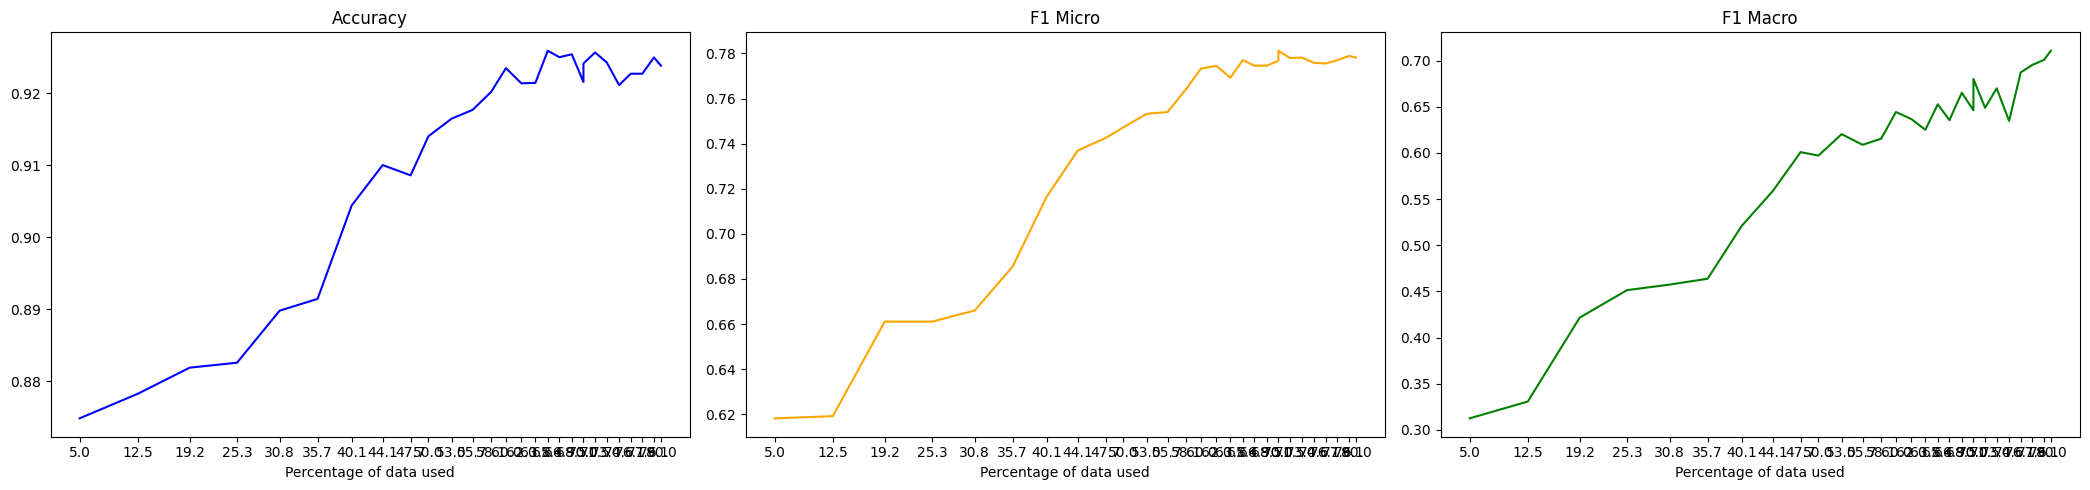

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5594, Accuracy: 0.83, F1 Micro: 0.0551, F1 Macro: 0.0221
Epoch 2/10, Train Loss: 0.4137, Accuracy: 0.8308, F1 Micro: 0.0458, F1 Macro: 0.0193
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3859, Accuracy: 0.8545, F1 Micro: 0.3506, F1 Macro: 0.1101
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.381, Accuracy: 0.8593, F1 Micro: 0.385, F1 Macro: 0.143
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3314, Accuracy: 0.8745, F1 Micro: 0.5708, F1 Macro: 0.2664
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2986, Accuracy: 0.8756, F1 Micro: 0.6144, F1 Macro: 0.3201
Epoch 7/10, Train Loss: 0.2684, Accuracy: 0.8795, F1 Micro: 0.6076, F1 Macro: 0.3376
Epoch 8/10, Train Loss: 0.2397, Accuracy: 0.8819, F1 Micro: 0.5874, F1 Macro: 0.3397
Epoch 9/10, Train Loss: 0.196, Accuracy: 0.8841, F1 Micro: 0.6091, F1 Macro: 0.3911
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.1865, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3909, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2325, Accuracy: 0.8487, F1 Micro: 0.3788, F1 Macro: 0.1421
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2012, Accuracy: 0.8543, F1 Micro: 0.5625, F1 Macro: 0.2549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1551, Accuracy: 0.8709, F1 Micro: 0.5656, F1 Macro: 0.2626
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1456, Accuracy: 0.8762, F1 Micro: 0.582, F1 Macro: 0.2884
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1169, Accuracy: 0.8759, F1 Micro: 0.6139, F1 Macro: 0.3143
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.881, F1 Micro: 0.607, F1 Macro: 0.3961
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.8749, F1 Micro: 0.6474, F1 Macro: 0.4047
Epoch 9/10, Train Loss: 0.0765, Accuracy: 0.8814, F1 Micro: 0.5847, F1 Macro: 0.3806
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3185, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1821, Accuracy: 0.8559, F1 Micro: 0.3578, F1 Macro: 0.1453
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1472, Accuracy: 0.8659, F1 Micro: 0.5529, F1 Macro: 0.2529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.121, Accuracy: 0.8731, F1 Micro: 0.5926, F1 Macro: 0.293
Epoch 5/10, Train Loss: 0.1051, Accuracy: 0.8757, F1 Micro: 0.5552, F1 Macro: 0.2974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.8748, F1 Micro: 0.6135, F1 Macro: 0.3183
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.8816, F1 Micro: 0.6203, F1 Macro: 0.3588
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0675, Accuracy: 0.8847, F1 Micro: 0.6429, F1 Macro: 0.4061
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.8797, F1 Micro: 0.644

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2845, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1741, Accuracy: 0.8602, F1 Micro: 0.465, F1 Macro: 0.2033
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1307, Accuracy: 0.8692, F1 Micro: 0.5659, F1 Macro: 0.2814
Epoch 4/10, Train Loss: 0.1094, Accuracy: 0.8751, F1 Micro: 0.5419, F1 Macro: 0.2712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0987, Accuracy: 0.8778, F1 Micro: 0.629, F1 Macro: 0.3667
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0768, Accuracy: 0.8852, F1 Micro: 0.644, F1 Macro: 0.426
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.8846, F1 Micro: 0.6552, F1 Macro: 0.4035
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.887, F1 Micro: 0.6456, F1 Macro: 0.3717
Epoch 9/10, Train Loss: 0.0449, Accuracy: 0.8886, F1 Micro: 0.647, F1 Macro: 0.4148
Epoch 10/10, Train Loss: 0.0388, Accuracy: 0.8879

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2723, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1785, Accuracy: 0.8621, F1 Micro: 0.4274, F1 Macro: 0.1912
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.145, Accuracy: 0.8757, F1 Micro: 0.6122, F1 Macro: 0.3036
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1151, Accuracy: 0.8748, F1 Micro: 0.632, F1 Macro: 0.4006
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0878, Accuracy: 0.8797, F1 Micro: 0.6358, F1 Macro: 0.4243
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0751, Accuracy: 0.8737, F1 Micro: 0.659, F1 Macro: 0.4468
Epoch 7/10, Train Loss: 0.0615, Accuracy: 0.8901, F1 Micro: 0.6348, F1 Macro: 0.4343
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.8849, F1 Micro: 0.6644, F1 Macro: 0.4555
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.8904, F1 Micro: 0.6541, F1 Macro: 0.4282
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.268, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1874, Accuracy: 0.8661, F1 Micro: 0.5119, F1 Macro: 0.2359
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1491, Accuracy: 0.8796, F1 Micro: 0.5979, F1 Macro: 0.3229
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1128, Accuracy: 0.8856, F1 Micro: 0.6537, F1 Macro: 0.4069
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0973, Accuracy: 0.8861, F1 Micro: 0.6729, F1 Macro: 0.4498
Epoch 6/10, Train Loss: 0.0677, Accuracy: 0.8827, F1 Micro: 0.6725, F1 Macro: 0.4517
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0583, Accuracy: 0.8942, F1 Micro: 0.6763, F1 Macro: 0.4493
Epoch 8/10, Train Loss: 0.0456, Accuracy: 0.8942, F1 Micro: 0.675, F1 Macro: 0.4769
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.8962, F1 Micro: 0.6722, F1 Macro: 0.4804
Epoch 10/10, Train Loss: 0.0313, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2718, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1801, Accuracy: 0.8639, F1 Micro: 0.4253, F1 Macro: 0.202
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1514, Accuracy: 0.8881, F1 Micro: 0.6356, F1 Macro: 0.3437
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1179, Accuracy: 0.8941, F1 Micro: 0.64, F1 Macro: 0.3514
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0845, Accuracy: 0.8941, F1 Micro: 0.6673, F1 Macro: 0.4336
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0719, Accuracy: 0.8945, F1 Micro: 0.6894, F1 Macro: 0.4806
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0595, Accuracy: 0.9015, F1 Micro: 0.7015, F1 Macro: 0.4919
Epoch 8/10, Train Loss: 0.054, Accuracy: 0.8978, F1 Micro: 0.6961, F1 Macro: 0.4819
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.8981, F1 Micro: 0.6947, F1 Macro: 0.4965
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2806, Accuracy: 0.8311, F1 Micro: 0.0408, F1 Macro: 0.0173
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2034, Accuracy: 0.8811, F1 Micro: 0.592, F1 Macro: 0.3153
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1513, Accuracy: 0.8893, F1 Micro: 0.6693, F1 Macro: 0.4238
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1175, Accuracy: 0.8841, F1 Micro: 0.6789, F1 Macro: 0.4864
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.095, Accuracy: 0.9005, F1 Micro: 0.7052, F1 Macro: 0.4756
Epoch 6/10, Train Loss: 0.0706, Accuracy: 0.9011, F1 Micro: 0.7052, F1 Macro: 0.5008
Epoch 7/10, Train Loss: 0.0596, Accuracy: 0.9015, F1 Micro: 0.6998, F1 Macro: 0.4898
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.8887, F1 Micro: 0.6978, F1 Macro: 0.4991
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9017, F1 Micro: 0.7102, F1 Macro: 0.4997
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2975, Accuracy: 0.8471, F1 Micro: 0.2136, F1 Macro: 0.0807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2021, Accuracy: 0.8858, F1 Micro: 0.5818, F1 Macro: 0.3503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1526, Accuracy: 0.9012, F1 Micro: 0.6721, F1 Macro: 0.4685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1229, Accuracy: 0.9053, F1 Micro: 0.7069, F1 Macro: 0.5254
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0938, Accuracy: 0.9082, F1 Micro: 0.7154, F1 Macro: 0.5442
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0795, Accuracy: 0.9049, F1 Micro: 0.731, F1 Macro: 0.5655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.062, Accuracy: 0.9084, F1 Micro: 0.7398, F1 Macro: 0.5898
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9107, F1 Micro: 0.7373, F1 Macro: 0.5917
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.9081, F1 Micro: 0.7385, F1 Macro: 0.5966
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3057, Accuracy: 0.8594, F1 Micro: 0.364, F1 Macro: 0.1618
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2059, Accuracy: 0.8907, F1 Micro: 0.5898, F1 Macro: 0.4024
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1541, Accuracy: 0.9056, F1 Micro: 0.7031, F1 Macro: 0.5249
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1247, Accuracy: 0.904, F1 Micro: 0.7336, F1 Macro: 0.5775
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0986, Accuracy: 0.9035, F1 Micro: 0.7358, F1 Macro: 0.592
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0757, Accuracy: 0.9104, F1 Micro: 0.7382, F1 Macro: 0.5888
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0577, Accuracy: 0.9115, F1 Micro: 0.7491, F1 Macro: 0.5997
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.9097, F1 Micro: 0.7429, F1 Macro: 0.6074
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.9103, F1 Micro: 0.7421, F1 Macro: 0.605
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3104, Accuracy: 0.8601, F1 Micro: 0.3552, F1 Macro: 0.1719
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2036, Accuracy: 0.9049, F1 Micro: 0.701, F1 Macro: 0.535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1617, Accuracy: 0.908, F1 Micro: 0.7331, F1 Macro: 0.5723
Epoch 4/10, Train Loss: 0.1223, Accuracy: 0.9136, F1 Micro: 0.733, F1 Macro: 0.5897
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0952, Accuracy: 0.9137, F1 Micro: 0.7486, F1 Macro: 0.6069
Epoch 6/10, Train Loss: 0.0787, Accuracy: 0.9153, F1 Micro: 0.7481, F1 Macro: 0.6096
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0594, Accuracy: 0.912, F1 Micro: 0.7532, F1 Macro: 0.6134
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9131, F1 Micro: 0.7432, F1 Macro: 0.6091
Epoch 9/10, Train Loss: 0.0444, Accuracy: 0.914, F1 Micro: 0.7506, F1 Macro: 0.6215
Epoch 10/10, Train Loss: 0.0357, Accuracy: 0.9071, F1 Micro: 0.7436, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3219, Accuracy: 0.8824, F1 Micro: 0.5722, F1 Macro: 0.3333
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2105, Accuracy: 0.9064, F1 Micro: 0.7075, F1 Macro: 0.5329
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1627, Accuracy: 0.9143, F1 Micro: 0.7403, F1 Macro: 0.5857
Epoch 4/10, Train Loss: 0.1241, Accuracy: 0.9068, F1 Micro: 0.7366, F1 Macro: 0.5833
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0986, Accuracy: 0.9132, F1 Micro: 0.7467, F1 Macro: 0.6044
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0768, Accuracy: 0.918, F1 Micro: 0.7573, F1 Macro: 0.61
Epoch 7/10, Train Loss: 0.0612, Accuracy: 0.9153, F1 Micro: 0.7496, F1 Macro: 0.6068
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9159, F1 Micro: 0.752, F1 Macro: 0.6149
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.9131, F1 Micro: 0.7539, F1 Macro: 0.6192
Epoch 10/10, Train Loss: 0.0399, Accuracy: 0.9195, F1 Micro: 0.7548, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3223, Accuracy: 0.8865, F1 Micro: 0.6106, F1 Macro: 0.3961
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2106, Accuracy: 0.9066, F1 Micro: 0.7209, F1 Macro: 0.5502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1675, Accuracy: 0.914, F1 Micro: 0.7413, F1 Macro: 0.5847
Epoch 4/10, Train Loss: 0.1281, Accuracy: 0.9177, F1 Micro: 0.7403, F1 Macro: 0.5993
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1032, Accuracy: 0.9089, F1 Micro: 0.7488, F1 Macro: 0.6025
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0777, Accuracy: 0.9148, F1 Micro: 0.7489, F1 Macro: 0.6088
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0622, Accuracy: 0.9161, F1 Micro: 0.7534, F1 Macro: 0.6029
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.916, F1 Micro: 0.7519, F1 Macro: 0.6118
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.913, F1 Micro: 0.7523, F1 Macro: 0.6144
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3213, Accuracy: 0.8804, F1 Micro: 0.5332, F1 Macro: 0.3148
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2042, Accuracy: 0.9084, F1 Micro: 0.7257, F1 Macro: 0.5677
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1584, Accuracy: 0.9156, F1 Micro: 0.7527, F1 Macro: 0.6101
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1259, Accuracy: 0.9136, F1 Micro: 0.7537, F1 Macro: 0.6115
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0975, Accuracy: 0.9186, F1 Micro: 0.7611, F1 Macro: 0.616
Epoch 6/10, Train Loss: 0.0794, Accuracy: 0.917, F1 Micro: 0.7516, F1 Macro: 0.6068
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9166, F1 Micro: 0.7568, F1 Macro: 0.6264
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9159, F1 Micro: 0.7568, F1 Macro: 0.6101
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.9199, F1 Micro: 0.7625, F1 Macro: 0.6377
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3215, Accuracy: 0.8949, F1 Micro: 0.6433, F1 Macro: 0.4087
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2064, Accuracy: 0.911, F1 Micro: 0.734, F1 Macro: 0.5816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1627, Accuracy: 0.9154, F1 Micro: 0.7564, F1 Macro: 0.608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1302, Accuracy: 0.9197, F1 Micro: 0.7607, F1 Macro: 0.6157
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1042, Accuracy: 0.9211, F1 Micro: 0.7667, F1 Macro: 0.6099
Epoch 6/10, Train Loss: 0.0815, Accuracy: 0.92, F1 Micro: 0.7655, F1 Macro: 0.6231
Epoch 7/10, Train Loss: 0.0628, Accuracy: 0.9202, F1 Micro: 0.7534, F1 Macro: 0.6186
Epoch 8/10, Train Loss: 0.0562, Accuracy: 0.9169, F1 Micro: 0.7549, F1 Macro: 0.6233
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9168, F1 Micro: 0.7605, F1 Macro: 0.6477
Epoch 10/10, Train Loss: 0.0395, Accuracy: 0.9191, F1 Micro: 0.7642, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3219, Accuracy: 0.8933, F1 Micro: 0.6508, F1 Macro: 0.4548
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2051, Accuracy: 0.9075, F1 Micro: 0.7372, F1 Macro: 0.5821
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1615, Accuracy: 0.9164, F1 Micro: 0.749, F1 Macro: 0.6082
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1307, Accuracy: 0.9201, F1 Micro: 0.7616, F1 Macro: 0.6191
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0984, Accuracy: 0.9197, F1 Micro: 0.7647, F1 Macro: 0.6223
Epoch 6/10, Train Loss: 0.0763, Accuracy: 0.918, F1 Micro: 0.7508, F1 Macro: 0.6147
Epoch 7/10, Train Loss: 0.066, Accuracy: 0.9204, F1 Micro: 0.7612, F1 Macro: 0.6362
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.9169, F1 Micro: 0.7648, F1 Macro: 0.6442
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9201, F1 Micro: 0.7637, F1 Macro: 0.6466
Epoch 10/10, Train Loss: 0.0413, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3245, Accuracy: 0.8944, F1 Micro: 0.6385, F1 Macro: 0.4303
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2078, Accuracy: 0.9116, F1 Micro: 0.7063, F1 Macro: 0.5297
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1706, Accuracy: 0.9179, F1 Micro: 0.7572, F1 Macro: 0.6089
Epoch 4/10, Train Loss: 0.1322, Accuracy: 0.9207, F1 Micro: 0.7568, F1 Macro: 0.6162
Epoch 5/10, Train Loss: 0.1027, Accuracy: 0.9204, F1 Micro: 0.7566, F1 Macro: 0.6115
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0822, Accuracy: 0.921, F1 Micro: 0.7623, F1 Macro: 0.6309
Epoch 7/10, Train Loss: 0.066, Accuracy: 0.9156, F1 Micro: 0.7582, F1 Macro: 0.6286
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9223, F1 Micro: 0.7613, F1 Macro: 0.6238
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0445, Accuracy: 0.9194, F1 Micro: 0.765, F1 Macro: 0.6492
Epoch 10/10, Train Loss: 0.0381, Accuracy: 0.9156, F1 Micro: 0.7599, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3243, Accuracy: 0.8966, F1 Micro: 0.6585, F1 Macro: 0.4302
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2107, Accuracy: 0.913, F1 Micro: 0.73, F1 Macro: 0.565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1624, Accuracy: 0.9107, F1 Micro: 0.7527, F1 Macro: 0.6016
Epoch 4/10, Train Loss: 0.1308, Accuracy: 0.9203, F1 Micro: 0.7515, F1 Macro: 0.6055
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1049, Accuracy: 0.9201, F1 Micro: 0.7574, F1 Macro: 0.6201
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0836, Accuracy: 0.9206, F1 Micro: 0.7663, F1 Macro: 0.6434
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.9233, F1 Micro: 0.7708, F1 Macro: 0.6358
Epoch 8/10, Train Loss: 0.0569, Accuracy: 0.9195, F1 Micro: 0.7659, F1 Macro: 0.6294
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9171, F1 Micro: 0.7635, F1 Macro: 0.633
Epoch 10/10, Train Loss: 0.0405, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.328, Accuracy: 0.8926, F1 Micro: 0.6311, F1 Macro: 0.3464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2165, Accuracy: 0.9138, F1 Micro: 0.7401, F1 Macro: 0.5901
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1673, Accuracy: 0.9123, F1 Micro: 0.7501, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1318, Accuracy: 0.9195, F1 Micro: 0.7632, F1 Macro: 0.6058
Epoch 5/10, Train Loss: 0.1028, Accuracy: 0.921, F1 Micro: 0.7538, F1 Macro: 0.6156
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0822, Accuracy: 0.9222, F1 Micro: 0.7685, F1 Macro: 0.6348
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9226, F1 Micro: 0.7715, F1 Macro: 0.6399
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.9215, F1 Micro: 0.7655, F1 Macro: 0.6555
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9195, F1 Micro: 0.7687, F1 Macro: 0.6492
Epoch 10/10, Train Loss: 0.0376, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3245, Accuracy: 0.8964, F1 Micro: 0.6524, F1 Macro: 0.4271
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2125, Accuracy: 0.9125, F1 Micro: 0.7414, F1 Macro: 0.5817
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.167, Accuracy: 0.9174, F1 Micro: 0.7559, F1 Macro: 0.5988
Epoch 4/10, Train Loss: 0.1327, Accuracy: 0.9091, F1 Micro: 0.7271, F1 Macro: 0.5909
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1071, Accuracy: 0.9215, F1 Micro: 0.7689, F1 Macro: 0.623
Epoch 6/10, Train Loss: 0.0849, Accuracy: 0.9177, F1 Micro: 0.7625, F1 Macro: 0.6438
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.9199, F1 Micro: 0.7644, F1 Macro: 0.646
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.9199, F1 Micro: 0.7644, F1 Macro: 0.6593
Epoch 9/10, Train Loss: 0.0519, Accuracy: 0.9187, F1 Micro: 0.7611, F1 Macro: 0.6562
Epoch 10/10, Train Loss: 0.0407, Accuracy: 0.9185, F1 Micro: 0.7515, F1 Macro: 0.6508
Iteration 9216: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3281, Accuracy: 0.8957, F1 Micro: 0.6896, F1 Macro: 0.4342
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2122, Accuracy: 0.9142, F1 Micro: 0.7391, F1 Macro: 0.5747
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1682, Accuracy: 0.9182, F1 Micro: 0.7619, F1 Macro: 0.6085
Epoch 4/10, Train Loss: 0.1343, Accuracy: 0.9191, F1 Micro: 0.7583, F1 Macro: 0.6176
Epoch 5/10, Train Loss: 0.1046, Accuracy: 0.9195, F1 Micro: 0.7609, F1 Macro: 0.6259
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.92, F1 Micro: 0.7672, F1 Macro: 0.638
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9153, F1 Micro: 0.7619, F1 Macro: 0.6461
Epoch 8/10, Train Loss: 0.0572, Accuracy: 0.9189, F1 Micro: 0.7661, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9226, F1 Micro: 0.769, F1 Macro: 0.6697
Epoch 10/10, Train Loss: 0.0422, Accuracy: 0.9201, F1 Micro: 0.7638, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3263, Accuracy: 0.901, F1 Micro: 0.6898, F1 Macro: 0.4496
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.214, Accuracy: 0.9144, F1 Micro: 0.7505, F1 Macro: 0.588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1659, Accuracy: 0.9214, F1 Micro: 0.763, F1 Macro: 0.6027
Epoch 4/10, Train Loss: 0.1318, Accuracy: 0.9221, F1 Micro: 0.761, F1 Macro: 0.6165
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1049, Accuracy: 0.9185, F1 Micro: 0.7678, F1 Macro: 0.636
Epoch 6/10, Train Loss: 0.0809, Accuracy: 0.9196, F1 Micro: 0.755, F1 Macro: 0.6311
Epoch 7/10, Train Loss: 0.0699, Accuracy: 0.9163, F1 Micro: 0.76, F1 Macro: 0.6437
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.9177, F1 Micro: 0.7589, F1 Macro: 0.6532
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9156, F1 Micro: 0.7604, F1 Macro: 0.6268
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0449, Accuracy: 0.9203, F1 Micro: 0.7697, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3215, Accuracy: 0.8962, F1 Micro: 0.7005, F1 Macro: 0.5065
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2119, Accuracy: 0.9137, F1 Micro: 0.7113, F1 Macro: 0.5619
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1684, Accuracy: 0.9158, F1 Micro: 0.7624, F1 Macro: 0.6067
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1289, Accuracy: 0.9179, F1 Micro: 0.7681, F1 Macro: 0.6303
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1041, Accuracy: 0.9223, F1 Micro: 0.7695, F1 Macro: 0.6255
Epoch 6/10, Train Loss: 0.0845, Accuracy: 0.924, F1 Micro: 0.765, F1 Macro: 0.6468
Epoch 7/10, Train Loss: 0.0698, Accuracy: 0.9238, F1 Micro: 0.7678, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.9227, F1 Micro: 0.7698, F1 Macro: 0.6658
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9233, F1 Micro: 0.7727, F1 Macro: 0.6752
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3241, Accuracy: 0.8989, F1 Micro: 0.6697, F1 Macro: 0.4825
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2106, Accuracy: 0.9152, F1 Micro: 0.7455, F1 Macro: 0.5765
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1623, Accuracy: 0.9225, F1 Micro: 0.7674, F1 Macro: 0.6212
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1306, Accuracy: 0.9216, F1 Micro: 0.7698, F1 Macro: 0.6264
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1094, Accuracy: 0.9242, F1 Micro: 0.7729, F1 Macro: 0.6482
Epoch 6/10, Train Loss: 0.0836, Accuracy: 0.9219, F1 Micro: 0.7705, F1 Macro: 0.6603
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9231, F1 Micro: 0.7688, F1 Macro: 0.6637
Epoch 8/10, Train Loss: 0.0541, Accuracy: 0.9212, F1 Micro: 0.7628, F1 Macro: 0.676
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9208, F1 Micro: 0.7701, F1 Macro: 0.6866
Epoch 10/10, Train Loss: 0.0404, Accuracy: 0.9191, F1 Micro: 0.7704, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3216, Accuracy: 0.8984, F1 Micro: 0.6994, F1 Macro: 0.5049
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2107, Accuracy: 0.9166, F1 Micro: 0.7479, F1 Macro: 0.5837
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.17, Accuracy: 0.9218, F1 Micro: 0.7593, F1 Macro: 0.6006
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1302, Accuracy: 0.9244, F1 Micro: 0.7703, F1 Macro: 0.6423
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1054, Accuracy: 0.923, F1 Micro: 0.7721, F1 Macro: 0.6463
Epoch 6/10, Train Loss: 0.0836, Accuracy: 0.919, F1 Micro: 0.7683, F1 Macro: 0.6507
Epoch 7/10, Train Loss: 0.0691, Accuracy: 0.9217, F1 Micro: 0.7703, F1 Macro: 0.6725
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9222, F1 Micro: 0.7707, F1 Macro: 0.6857
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9194, F1 Micro: 0.7699, F1 Macro: 0.678
Epoch 10/10, Train Loss: 0.0413, Accuracy: 0.9234, F1 Micro: 0.7698, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3215, Accuracy: 0.8959, F1 Micro: 0.6248, F1 Macro: 0.434
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2179, Accuracy: 0.9145, F1 Micro: 0.7401, F1 Macro: 0.5764
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1686, Accuracy: 0.921, F1 Micro: 0.7618, F1 Macro: 0.6121
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1358, Accuracy: 0.9226, F1 Micro: 0.7747, F1 Macro: 0.6537
Epoch 5/10, Train Loss: 0.1085, Accuracy: 0.922, F1 Micro: 0.7725, F1 Macro: 0.6568
Epoch 6/10, Train Loss: 0.0846, Accuracy: 0.9188, F1 Micro: 0.7694, F1 Macro: 0.6844
Epoch 7/10, Train Loss: 0.0701, Accuracy: 0.9197, F1 Micro: 0.7681, F1 Macro: 0.6772
Epoch 8/10, Train Loss: 0.0565, Accuracy: 0.9215, F1 Micro: 0.7734, F1 Macro: 0.6846
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9233, F1 Micro: 0.7711, F1 Macro: 0.695
Epoch 10/10, Train Loss: 0.0394, Accuracy: 0.922, F1 Micro: 0.7731, F1 Macro: 0.7086
Iteration 10218: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3242, Accuracy: 0.9009, F1 Micro: 0.6898, F1 Macro: 0.5186
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2147, Accuracy: 0.9159, F1 Micro: 0.7295, F1 Macro: 0.5659
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1715, Accuracy: 0.9194, F1 Micro: 0.7613, F1 Macro: 0.6133
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1394, Accuracy: 0.9211, F1 Micro: 0.7648, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1091, Accuracy: 0.9244, F1 Micro: 0.7757, F1 Macro: 0.685
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.9221, F1 Micro: 0.7753, F1 Macro: 0.6939
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.921, F1 Micro: 0.7658, F1 Macro: 0.6865
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.922, F1 Micro: 0.7664, F1 Macro: 0.7031
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9197, F1 Micro: 0.7703, F1 Macro: 0.7057
Epoch 10/10, Train Loss: 0.0393, Accuracy: 0.9212, F1 Micro: 0.7739, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3277, Accuracy: 0.902, F1 Micro: 0.668, F1 Macro: 0.4428
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2195, Accuracy: 0.916, F1 Micro: 0.7372, F1 Macro: 0.5779
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1676, Accuracy: 0.924, F1 Micro: 0.7632, F1 Macro: 0.6086
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1368, Accuracy: 0.9196, F1 Micro: 0.7776, F1 Macro: 0.681
Epoch 5/10, Train Loss: 0.1087, Accuracy: 0.9187, F1 Micro: 0.7703, F1 Macro: 0.6785
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.9239, F1 Micro: 0.7753, F1 Macro: 0.7002
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9249, F1 Micro: 0.778, F1 Macro: 0.708
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.921, F1 Micro: 0.7728, F1 Macro: 0.709
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.9252, F1 Micro: 0.7818, F1 Macro: 0.7159
Epoch 10/10, Train Loss: 0.041, Accuracy: 0.926

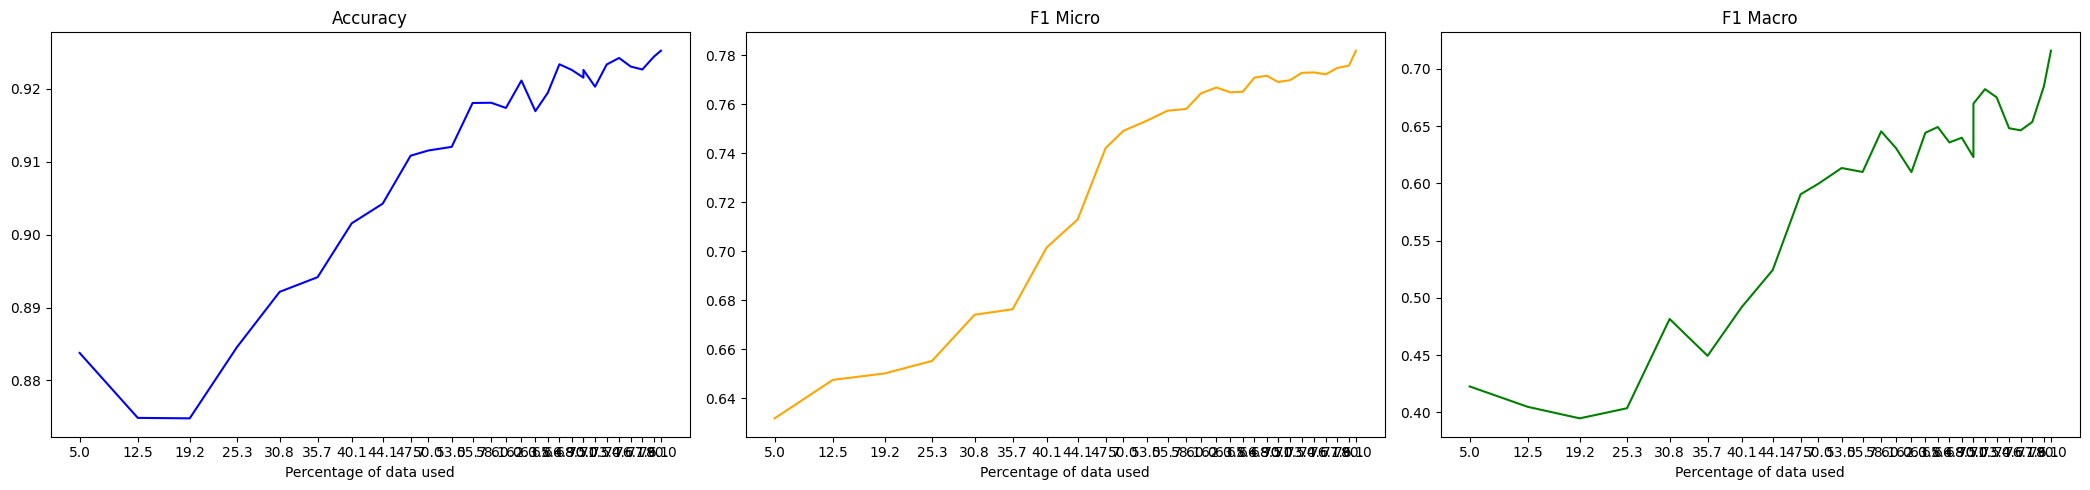

In [ ]:
active_learning(seeds[4], 4)